# This file contains an analysis of the effect of Obstructive Sleep Apnea on endothelial function.

In [1]:
options(warn=-1)
homedir <- "C:/Users/breng/Desktop/final miR210 analysis"
funcsfile <- "miR210_functions_2.r"
funcsfilepy <- "miR210_python_functions.py"
Organ <- "Homo sapiens" 
BioMartdataset <-"hsapiens_gene_ensembl"
# datasets
miRNAseq <- "./data/miRNA_chypoxia_data/GSE116909_Supplemental_Tab._2.csv"
combinedDT <- "./data/3 ucsd_xian_taiwan_updated.csv" #"3 ucsd_xian_taiwan.xls"
osaseq <- "./data/19 OSA RNAseq raw merge genes.xls"          
# libraries
suppressMessages({
    library(stringi)
    library(data.table)
    library(ggplot2)
    library(ggpubr)
    library(MyPackage)
    library(reticulate)
    library(purrr)
    library(dplyr)
    # propensity score matching
    library(Matching)
    # correaltion analysis
    library(Hmisc)
    library(corrplot)
    # motif analysis
    library(biomaRt)
    library(seqinr)
    library(rtracklayer)
    library(GenomicRanges)
    library(ConservationtextmineR)
    library(Biostrings)
    library(seqLogo)
    library(BCRANK)
    library(JASPAR)
    # RNAseq
    library(systemPipeR);
    library(ShortRead)
    library(ConservationtextmineR)
    library(RColorBrewer)
    library(pheatmap)
    library(GenomicFeatures)
    library(BiocParallel)
    # KEGG pathway analysis
    library(pathview)
    library(gage)
    library(IRdisplay)
})
setwd(homedir)
source(funcsfile)
source_python(funcsfilepy)
namestr = list(
  condition = c("normal","mild","moderate","severe","unknown"),
  location = c("UCSD","taiwan","xian", "taiwan_new"))

## Analysis of miRNAseq data

In [2]:
dt <- fread(miRNAseq)
dt <- dt[,c(1, 2, 4, 6, 3, 5, 7)][(dt$`Chronic hypoxia 3 h 12 min` > 0 & dt$`Chronic hypoxia 8 h` > 0 & dt$`Chronic hypoxia 14 h 24 min` > 0 &
                                  dt$`Cyclic hypoxia Cycle 2` > 0 & dt$`Cyclic hypoxia Cycle 5` > 0 & dt$`Cyclic hypoxia Cycle 9` > 0) |
                                  (dt$`Chronic hypoxia 3 h 12 min` < 0 & dt$`Chronic hypoxia 8 h` < 0 & dt$`Chronic hypoxia 14 h 24 min` < 0 &
                                  dt$`Cyclic hypoxia Cycle 2` < 0 & dt$`Cyclic hypoxia Cycle 5` < 0 & dt$`Cyclic hypoxia Cycle 9` < 0),]
bothup <-intersect(dt[dt$`Chronic hypoxia 3 h 12 min` < dt$`Chronic hypoxia 8 h` & dt$`Chronic hypoxia 8 h` < dt$`Chronic hypoxia 14 h 24 min`,]$`miRNA name`,
                   dt[dt$`Cyclic hypoxia Cycle 2` < dt$`Cyclic hypoxia Cycle 5` & dt$`Cyclic hypoxia Cycle 5` < dt$`Cyclic hypoxia Cycle 9`,]$`miRNA name`)

str(dt)

Classes 'data.table' and 'data.frame':	81 obs. of  7 variables:
 $ miRNA name                 : chr  "hsa-let-7c-3p" "hsa-miR-100-3p" "hsa-miR-1264" "hsa-miR-1284" ...
 $ Chronic hypoxia 3 h 12 min : num  -1.1 -1.68 -3.34 -1.23 -1.35 -2.22 1.02 -1.22 -1.66 -2.09 ...
 $ Chronic hypoxia 8 h        : num  -1.6 -1.87 -1.93 -1.47 -1.93 -1.65 1.11 -2.01 -2.12 -1.8 ...
 $ Chronic hypoxia 14 h 24 min: num  -2 -2.42 -2.26 -1.97 -2.62 -2.15 1.12 -1.97 -2.86 -1.96 ...
 $ Cyclic hypoxia Cycle 2     : num  -1.73 -1.37 -2.1 -1.45 -1.15 -1.72 1.8 -1.98 -1.29 -1.34 ...
 $ Cyclic hypoxia Cycle 5     : num  -2.01 -1.45 -1.37 -2.14 -1.12 -1.42 2.18 -2.05 -1.67 -1.2 ...
 $ Cyclic hypoxia Cycle 9     : num  -1.68 -1.16 -1.78 -1.81 -1.1 -2 2.2 -1.8 -1.3 -1.53 ...
 - attr(*, ".internal.selfref")=<externalptr> 


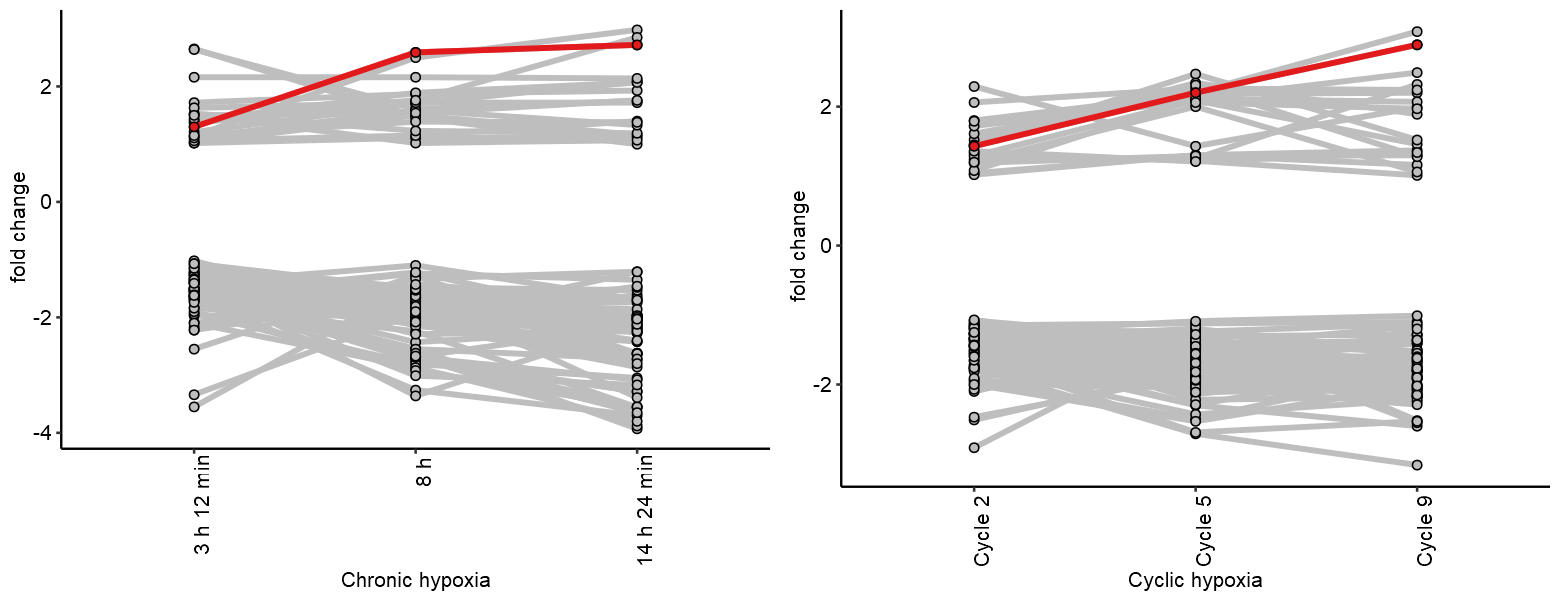

In [3]:
options(repr.plot.width=13, repr.plot.height=5)
mel <- melt(dt, id = 1)
mel$status <- "NA"
mel[(mel$`miRNA name` %in% bothup),]$status <- "trend"
mel[!(mel$`miRNA name` %in% bothup),]$status <- "no_trend"
mel$variable <- stri_replace_all_fixed(mel$variable, pattern = c("Chronic hypoxia ", "Cyclic hypoxia "), 
                                       replacement = c(""), vectorize_all = FALSE)
mel$variable <- factor(mel$variable, levels= c("3 h 12 min", "8 h", "14 h 24 min", "Cycle 2", "Cycle 5", "Cycle 9"),
                       labels = c("3 h 12 min", "8 h", "14 h 24 min", "Cycle 2", "Cycle 5", "Cycle 9"))

p1 <- ggplot(data=mel, aes(x=variable, y=value, group=`miRNA name`))+
  theme_pubr()+
  geom_line(data = mel[mel$variable == "3 h 12 min" | mel$variable == "8 h" | mel$variable == "14 h 24 min" ,], 
            aes(x=variable, y=value), size = 1.25, colour = "gray")+
  geom_point(data = mel[mel$variable == "3 h 12 min" | mel$variable == "8 h" | mel$variable == "14 h 24 min" ,],
             shape = 21, size = 2, colour = "black", fill = "gray")+
  geom_line(data = mel[mel$variable == "3 h 12 min" & mel$`miRNA name` == "hsa-miR-210-3p" | 
                       mel$variable == "8 h" & mel$`miRNA name` == "hsa-miR-210-3p" | 
                       mel$variable == "14 h 24 min" & mel$`miRNA name` == "hsa-miR-210-3p",], 
            aes(x=variable, y=value), size = 1.25, colour = "#E31A1C")+
  geom_point(data = mel[mel$variable == "3 h 12 min" & mel$`miRNA name` == "hsa-miR-210-3p" | 
                        mel$variable == "8 h" & mel$`miRNA name` == "hsa-miR-210-3p" | 
                        mel$variable == "14 h 24 min" & mel$`miRNA name` == "hsa-miR-210-3p",],
             aes(x=variable, y=value), shape = 21, size = 2, colour = "black", fill = "#E31A1C")+  
  theme(axis.text.x = element_text(angle = 90, hjust = 1))+ylab("fold change")+xlab("Chronic hypoxia")

p2 <- ggplot(data=mel, aes(x=variable, y=value, group=`miRNA name`))+
  theme_pubr()+
  geom_line(data = mel[mel$variable == "Cycle 2" | mel$variable == "Cycle 5"  | mel$variable == "Cycle 9" ,],
            aes(x=variable, y=value), size = 1.25, colour = "gray")+
  geom_point(data = mel[mel$variable == "Cycle 2" | mel$variable == "Cycle 5"  | mel$variable == "Cycle 9" ,],
             shape = 21, size = 2, colour = "black", fill = "gray")+
  geom_line(data = mel[mel$variable == "Cycle 2" & mel$`miRNA name` == "hsa-miR-210-3p" | 
                       mel$variable == "Cycle 5" & mel$`miRNA name` == "hsa-miR-210-3p" | 
                       mel$variable == "Cycle 9" & mel$`miRNA name` == "hsa-miR-210-3p",],
            aes(x=variable, y=value), size = 1.25, colour = "#E31A1C")+
  geom_point(data = mel[mel$variable == "Cycle 2" & mel$`miRNA name` == "hsa-miR-210-3p" | 
                        mel$variable == "Cycle 5" & mel$`miRNA name` == "hsa-miR-210-3p" | 
                        mel$variable == "Cycle 9" & mel$`miRNA name` == "hsa-miR-210-3p",],
             aes(x=variable, y=value), shape = 21, size = 2, colour = "black", fill = "#E31A1C")+
  theme(axis.text.x = element_text(angle = 90, hjust = 1))+ylab("fold change")+xlab("Cyclic hypoxia")
multiplot(p1, p2, cols = 2)
#tiff(file = "./results/miR levels mir210 only.tiff", width = 1200, height = 750, units = "px", res = 300); p1; dev.off()

## Analysis of clinical data

### Clean clinical data

In [4]:
options(warn=-1)
dt <- fread(combinedDT)
#### Format column names
colnames(dt)[grep("tst", colnames(dt))] <- "tst"
colnames(dt)[grep("nadir", colnames(dt))] <- "sao2_nadir"
colnames(dt)[grep("protein", colnames(dt))] <- 'proteinuria'
colnames(dt)[grep("weight_status", colnames(dt))] <- 'obesity'
colnames(dt) <- gsub("-| ", "_", colnames(dt))
#### remove empty columns
dt$`relative_fold_change` <- NULL
dt$hypoxia_category <- NULL
dt$unknown <- NULL
dt$hs_crp <- NULL
dt$total_ahi <- NULL
#### Subset and convert columns to numeric
dt[ldl == "COMMENT",]$ldl <- NA
dt$ldl <- as.numeric(dt$ldl)
dt$height <- as.numeric(dt$height)
dt$`tst` <- as.numeric(gsub("%", "",dt$`tst` , fixed = TRUE))
dt$hba1c <- as.numeric(gsub("%", "",dt$hba1c , fixed = TRUE))
dt$`sao2_nadir` <- as.numeric(dt$`sao2_nadir`)
dt$crp <- as.numeric(dt$crp)
dt$ast <- as.numeric(dt$ast)
dt$alt <- as.numeric(dt$alt)
#### re-label colums to be consistent between datasets
dt[sex == "male"]$sex <- "M"; dt[sex == "female"]$sex <- "F"
dt[,obesity:=ifelse(obesity == "obesity"| obesity == "overweight" | obesity == "I" | obesity == "II","Y","N")]
dt[,htn:=ifelse(htn == "Yes" | htn == "1","Y","N")]
dt[,chd:=ifelse(chd == "Yes" | chd == "1","Y","N")]
dt[,dm:=ifelse(dm == "Yes" | dm == "1","Y","N")]
dt[,stroke:=ifelse(stroke == "Yes" | stroke == "1","Y","N")]
#### convert binary numeric columns to character
dt[,smoking:=ifelse(smoking == 1,"Y","N")]
dt[,afib:=ifelse(afib == 1,"Y","N")]
dt[,chf:=ifelse(chf == 1,"Y","N")]
dt[,ami:=ifelse(ami == 1,"Y","N")]
dt[,ckd:=ifelse(ckd == 1,"Y","N")]
dt[,oha:=ifelse(oha == 1,"Y","N")]
dt[,proteinuria:=ifelse(proteinuria == 1,"Y","N")]
dt[,cpap:=ifelse(cpap == "positive","Y","N")]
#### convert foreign units into american ###########################
cols <- names(dt[,c('glucose','t_chol','tg','hdl','ldl')])
dt[source == "xian",(cols):=lapply(.SD, function(x) x*18), .SDcols = cols]                                   
#### calculate OSA severity based on standard numbers
new <- dt[source == namestr[[2]][4],]  
dt <- dt[!source == namestr[[2]][4],] 
dt$severity <- OSAannotate(DT = dt)
dt <- rbind(dt, new)
dt$osa_group <- "normal"; dt[severity == "mild" | severity == "moderate" | severity == "severe",]$osa_group <- "OSA"  
#writab(dt, fname = "./data/sample.xls")

#### Calculate the ${\Delta CT}$ value for each miRNA which normalizes its expression to the loading control
$ {\Delta CT} = 2^{loading - measured} $

In [5]:
dt[,delta_ct_210 := (2^(dt$cel_mir39_ct - dt$mir210_ct))]
dt[,delta_ct_92a := (2^(dt$cel_mir39_ct - dt$mir92a_ct))]
dt[,delta_ct_21 := (2^(dt$cel_mir39_ct - dt$mir21_ct))]

#### Normalize the expression level of miR210, miR92a, and miR21 to the average of the control group for each site.

In [6]:
meangdt210 = dt[severity == "normal" ,.(meanave = meanna(delta_ct_210)), .(source)]; setkey(meangdt210,source)
meangdt92 = dt[severity == "normal" ,.(meanave = meanna(delta_ct_92a)), .(source)]; setkey(meangdt92,source)
meangdt21 = dt[severity == "normal" ,.(meanave = meanna(delta_ct_21)), .(source)]; setkey(meangdt21,source)
meangdt = list(meangdt210,meangdt92,meangdt21)#; meangdt#[[1]][1]

In [7]:
dt[,c("mir210_FC"):= norm(d210=delta_ct_210, d92=NA, d21=NA, source), .(osa_group)][,log2_mir210_FC := log2(dt$mir210_FC)]
dt[,c("mir92_FC"):= norm(d210=NA, d92=delta_ct_92a, d21=NA, source), .(osa_group)][,log2_mir92_FC := log2(dt$mir92_FC)]
dt[,c("mir21_FC"):= norm(d210=NA, d92=NA, d21=delta_ct_21, source), .(osa_group)][,log2_mir21_FC := log2(dt$mir21_FC)]
dt <- dt[,c(1, 56, 2:7, 58:64, 8:15, 57, 16:55)]
#writab(dt, fname = "./data/4.1 ucsd_xian_taiwan dct.xls")

#### Take the log2 of the AHI and ODI

In [8]:
dt[,log2_ahi := log2(dt$ahi)]; dt[log2_ahi == "-Inf",]$log2_ahi <- NA
dt[,log2_odi := log2(dt$odi)]; dt[log2_odi == "-Inf",]$log2_odi <- NA

In [9]:
dt[,log2_mir210_dct := log2(dt$delta_ct_210)]

#### Use only xian and taiwan datasets

In [10]:
c(namestr[['location']][3], namestr[['location']][4])
dt <- dt[source == namestr[['location']][3] | source == namestr[['location']][4],]
dt[!duplicated(dt$source),]$source

[1] "xian"       "taiwan_new"

[1] "xian"       "taiwan_new"

#### Frequency counts for binary categorical columns

In [11]:
bincols <- c("obesity", "htn", "chd", "dm", "stroke", "cpap","smoking","afib","chf","ami","ckd","oha","proteinuria")
t(sapply(X = dt[, ..bincols], FUN = table)) 

,N,Y
obesity,31,70
htn,51,50
chd,75,2
dm,84,17
stroke,99,2
cpap,41,2
smoking,21,18
afib,38,1
chf,36,3
ami,36,3


#### Frequency counts for remaining columns

In [12]:
contcols <- c("source", "severity", "osa_group", "sex")
f <- function(b) head(freqsdt("dt",b), 4)
lapply(contcols,f)

source,frequency,percent
<chr>,<int>,<dbl>
xian,58,57.42574
taiwan_new,43,42.57426
severity,frequency,percent
<chr>,<int>,<dbl>
normal,37,36.63366
mild,23,22.77228
severe,21,20.79208
moderate,16,15.84158
osa_group,frequency,percent


#### Determine which sources analyzed which miRNAs

In [13]:
c(namestr[['location']][3], namestr[['location']][4])
data.table(source = c(namestr[['location']][3], namestr[['location']][4]),
            miR210 = c(!sum(is.na(dt[dt$source == namestr[['location']][3],]$mir210_ct)) == length(dt[dt$source == namestr[['location']][3],]$mir210_ct),
                       !sum(is.na(dt[dt$source == namestr[['location']][4],]$mir210_ct)) == length(dt[dt$source == namestr[['location']][4],]$mir210_ct)),
            miR92a = c(!sum(is.na(dt[dt$source == namestr[['location']][3],]$mir92a_ct)) == length(dt[dt$source == namestr[['location']][3],]$mir92a_ct),
                       !sum(is.na(dt[dt$source == namestr[['location']][4],]$mir92a_ct)) == length(dt[dt$source == namestr[['location']][4],]$mir92a_ct)),
            miR21 = c(!sum(is.na(dt[dt$source == namestr[['location']][3],]$mir21_ct)) == length(dt[dt$source == namestr[['location']][3],]$mir21_ct),
                      !sum(is.na(dt[dt$source == namestr[['location']][4],]$mir21_ct)) == length(dt[dt$source == namestr[['location']][4],]$mir21_ct)))

[1] "xian"       "taiwan_new"

source,miR210,miR92a,miR21
<chr>,<lgl>,<lgl>,<lgl>
xian,TRUE,TRUE,TRUE
taiwan_new,TRUE,FALSE,FALSE


### Run normality tests on the data 

#### Shapiro-Wilk’s test of normaliy

In [14]:
cols = c("cel_mir39_ct","mir210_ct","mir92a_ct","mir21_ct","delta_ct_210","delta_ct_92a","delta_ct_21","mir210_FC",
         "log2_mir210_FC", "mir92_FC","log2_mir92_FC","mir21_FC","log2_mir21_FC","age","bmi","weight","height","ahi",
        "insulin","crp","glucose","ast","alt","t_chol","tg","hdl","ldl","chol_hdl_ratio","odi","tst","sao2_nadir",
        "hba1c","bun","cr","rhi","hb","platelet","cr_base","egfr_c_g","uric_acid","log2_ahi","log2_odi")
normalityfindR(DT = dt, cols = cols)

method,pvalue,variable,normality
<chr>,<dbl>,<chr>,<chr>
Shapiro-Wilk normality test,4.894500e-05,cel_mir39_ct,Not normally distributed
Shapiro-Wilk normality test,9.733333e-02,mir210_ct,normally distributed
Shapiro-Wilk normality test,2.343515e-06,mir92a_ct,Not normally distributed
Shapiro-Wilk normality test,2.988500e-01,mir21_ct,normally distributed
Shapiro-Wilk normality test,2.063063e-19,delta_ct_210,Not normally distributed
Shapiro-Wilk normality test,2.216131e-16,delta_ct_92a,Not normally distributed
Shapiro-Wilk normality test,2.218664e-15,delta_ct_21,Not normally distributed
Shapiro-Wilk normality test,2.748340e-21,mir210_FC,Not normally distributed
Shapiro-Wilk normality test,2.466567e-01,log2_mir210_FC,normally distributed


#### QQplots to check for data normality

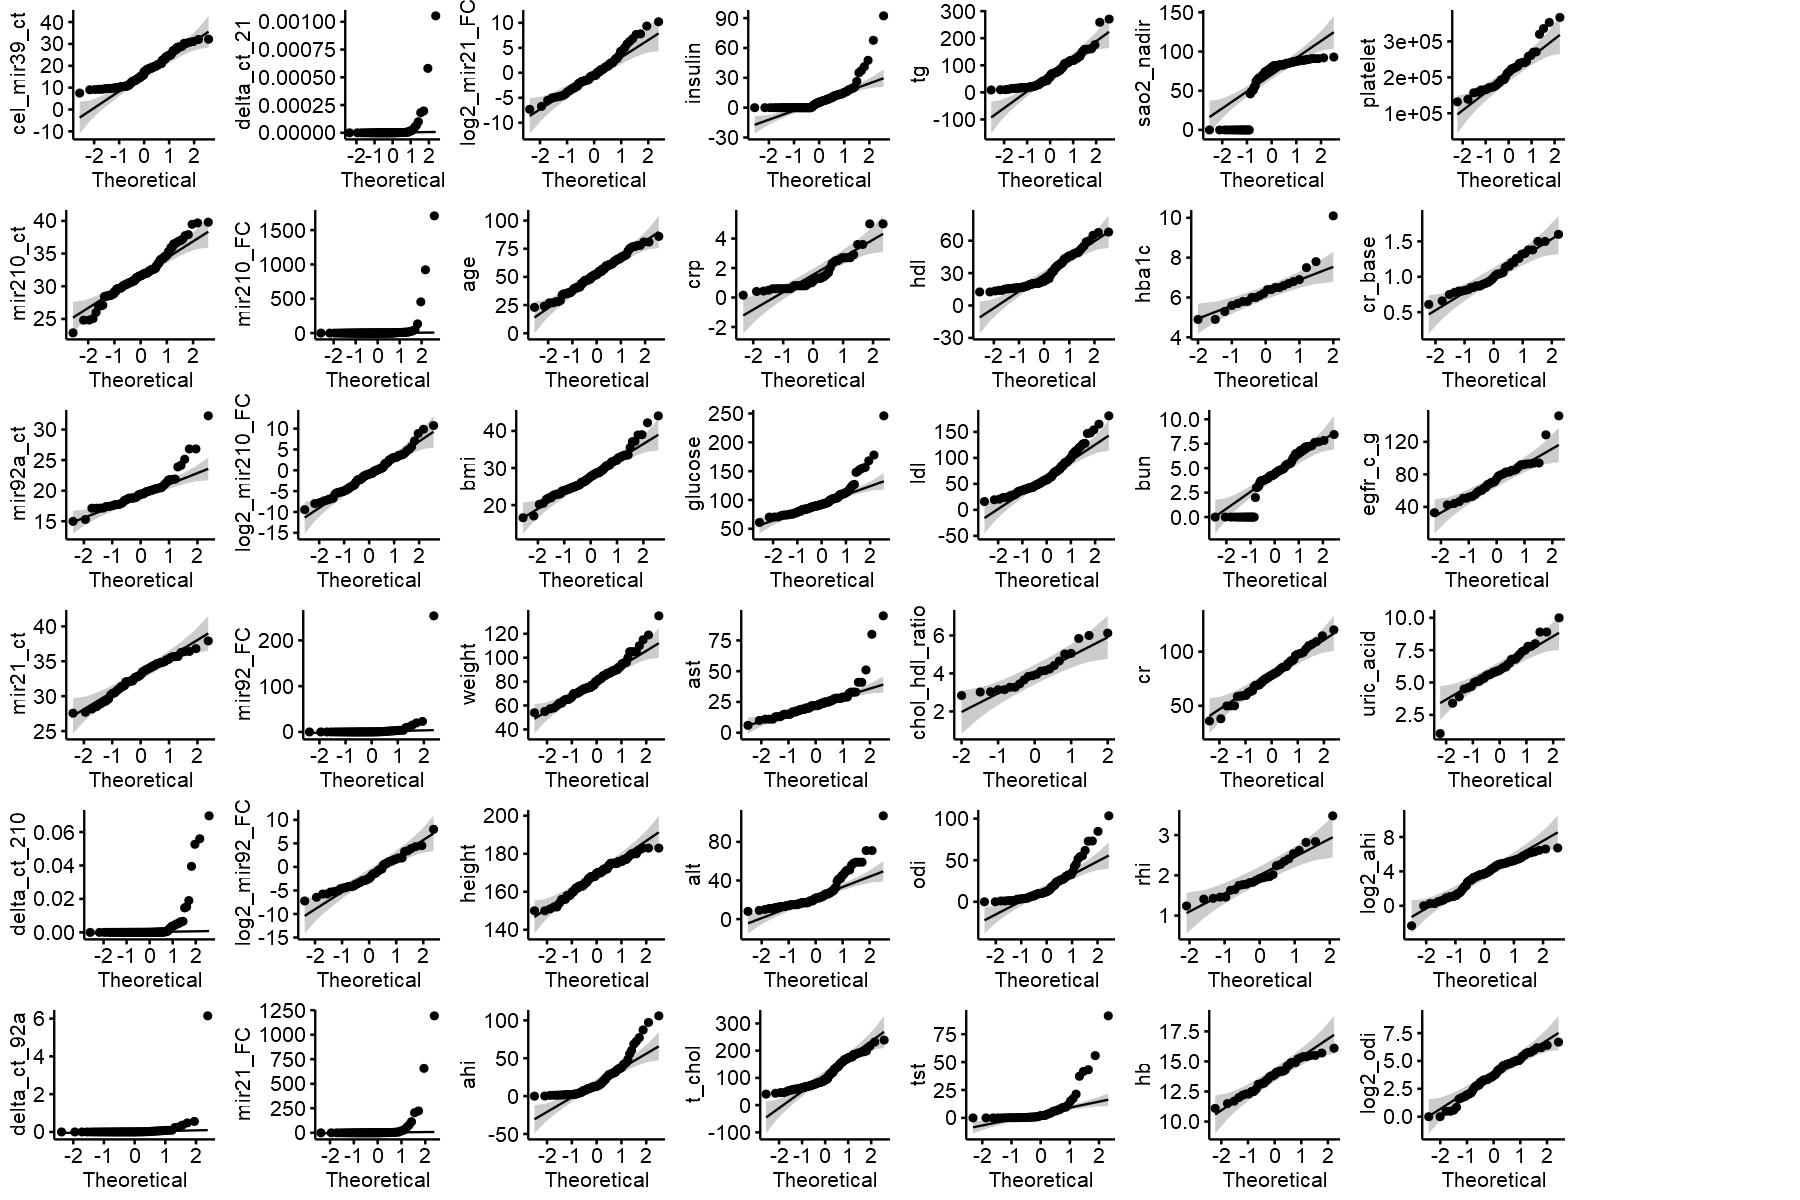

In [15]:
options(repr.plot.width=15, repr.plot.height=10)
plot <- list()
for(i in 1:length(cols)){
plot[[i]] <- ggqqplot(dt[[cols[i]]])+ylab(cols[i])
}
multiplot(plotlist=plot, cols = 8)

#### Histograms to assess data normality

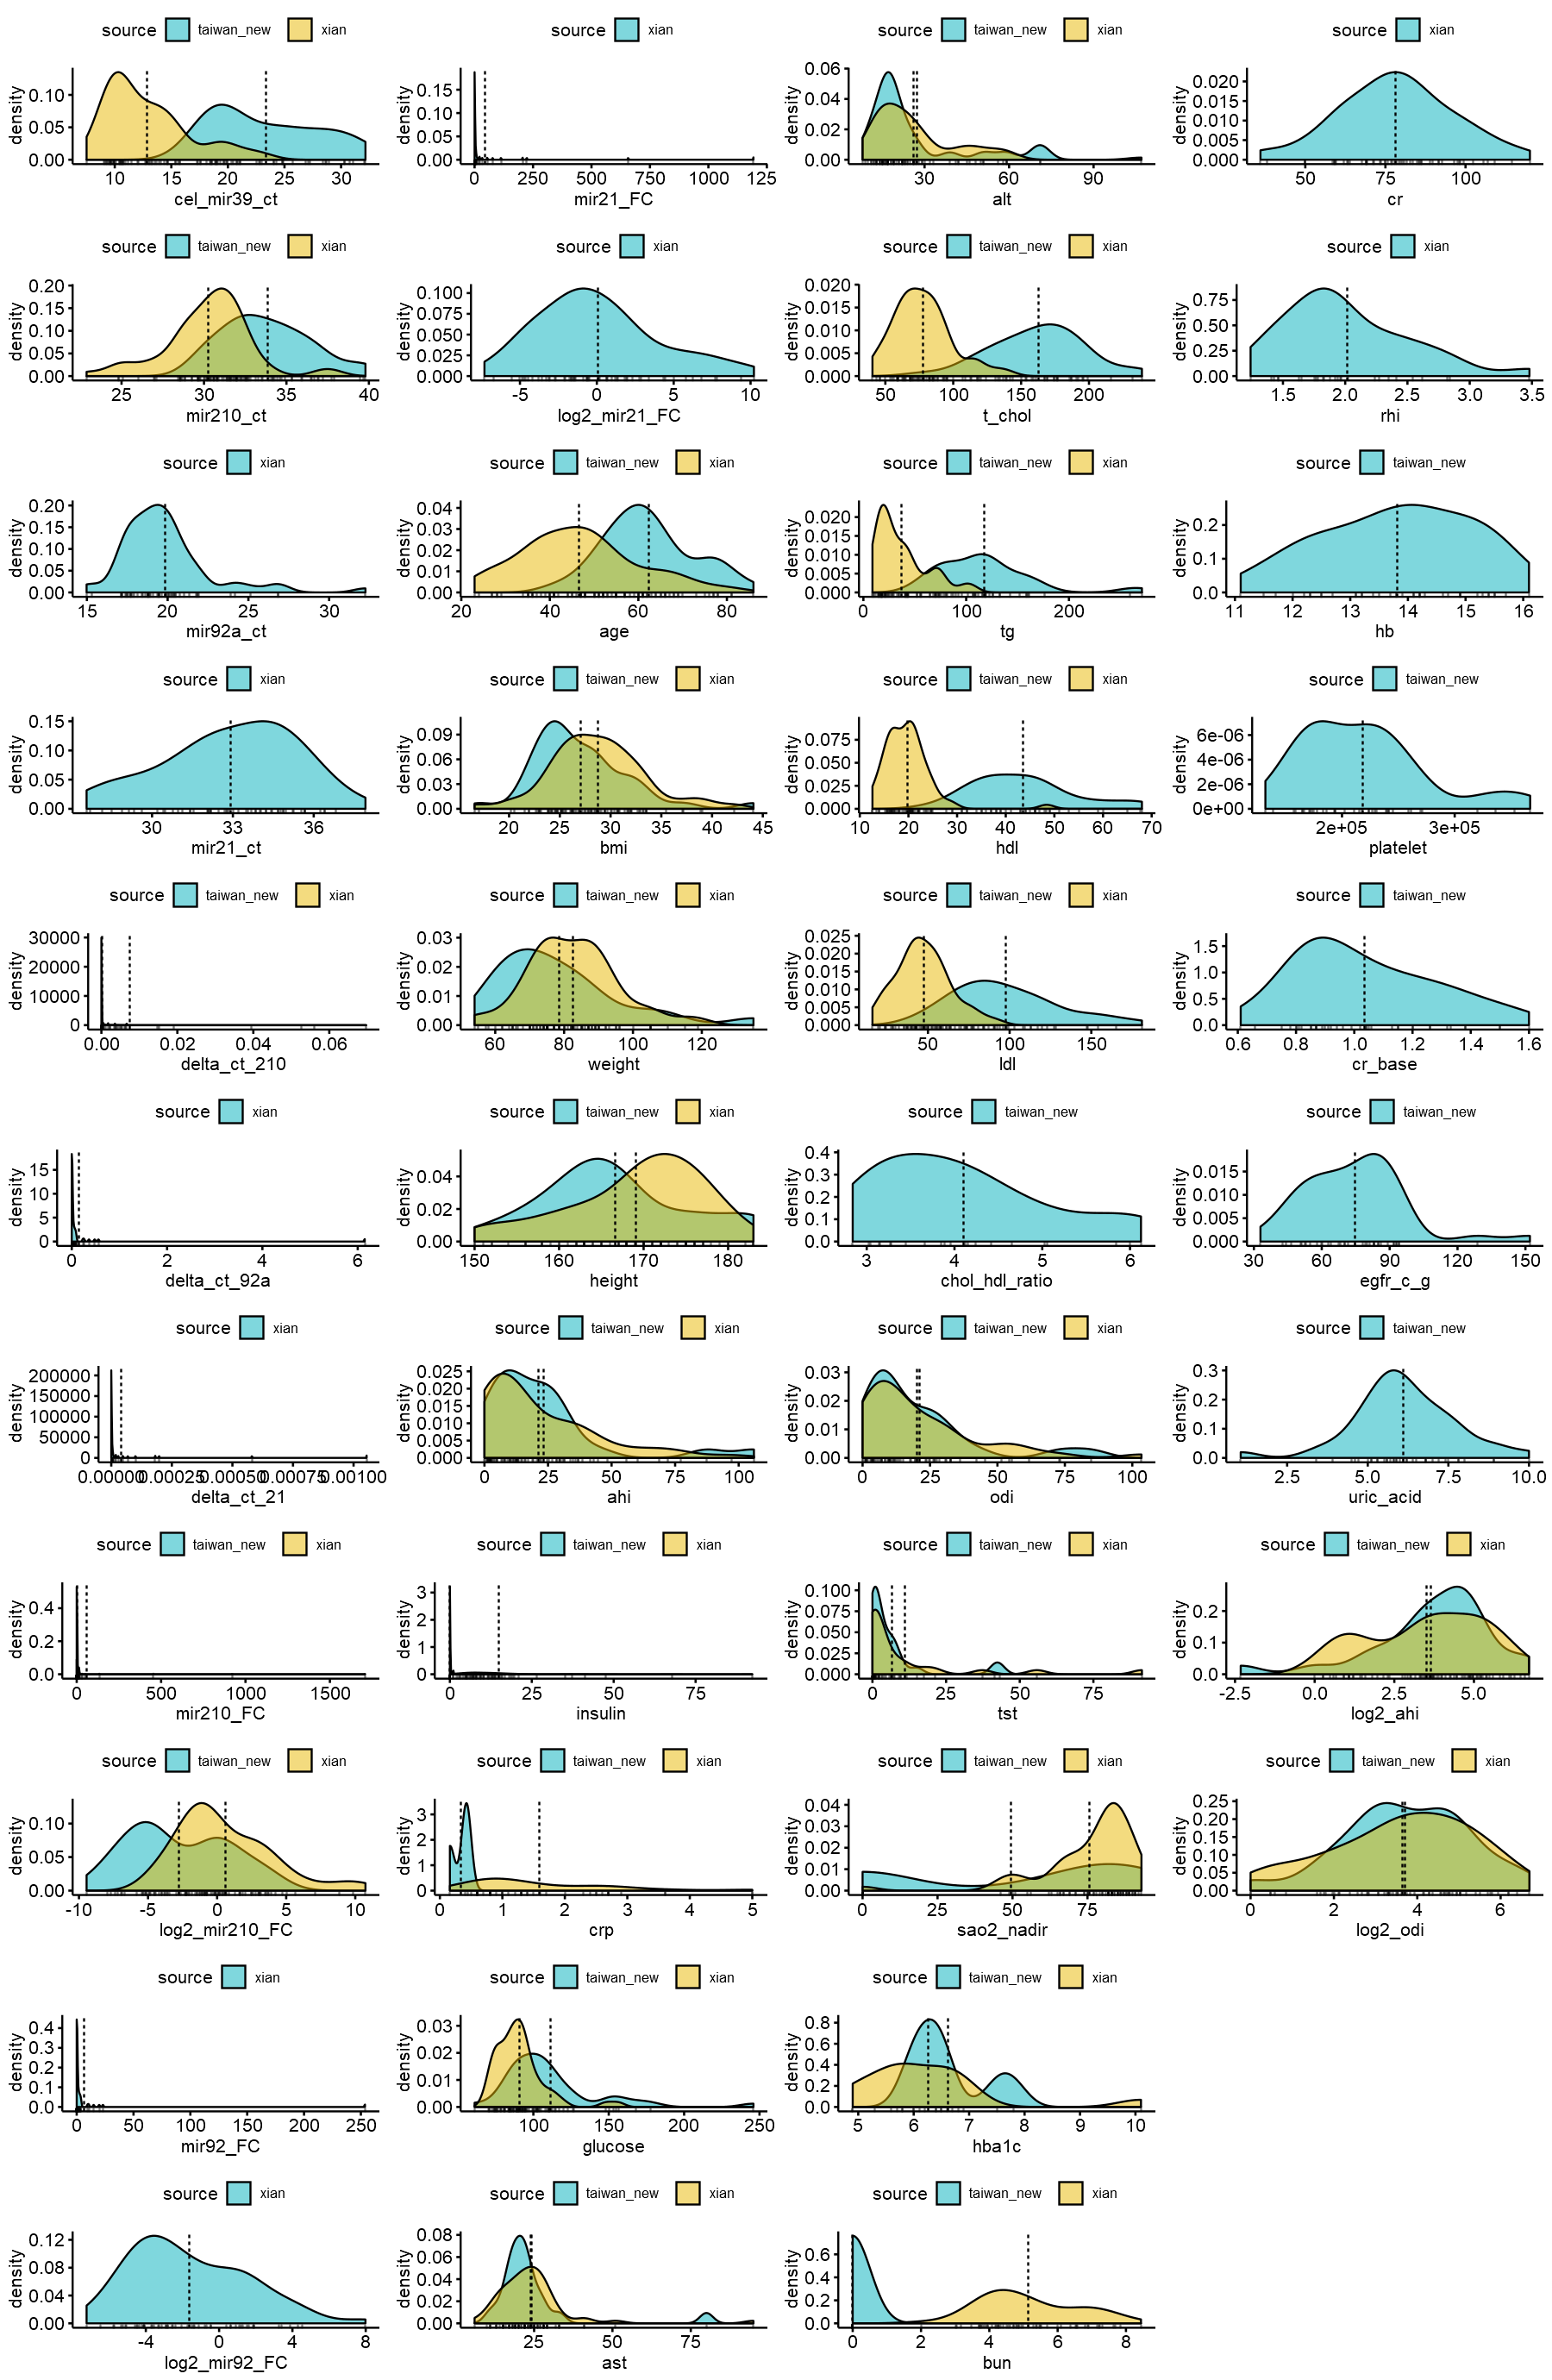

In [16]:
options(repr.plot.width=15, repr.plot.height=23)
plot <- list()
for(i in 1:length(cols)){
plot[[i]] <- ggdensity(dt, x = cols[i], add = "mean", rug = TRUE, , fill = "source",
   palette = c("#00AFBB", "#E7B800"))}#color = "#00AFBB", fill = "#00AFBB", bins = 50)}#gghistogram
multiplot(plotlist=plot, cols = 4)

### Xi'an data only

#### Analyze what attributes can predict outcome (OSA or not)

For the first portion of this analysis, the severity of OSA will be reduced to a binary categorical column indicating Y (1) for a record that has OSA or N (0) for someone who does not

In [17]:
dt_sub <- dt[,c(2:33,35:46,65:66)][,outcome := osa_group][,osa_group := NULL][source == "xian" ,]
#colnames(dt_sub)
dt_sub[,outcome:=ifelse(outcome == "OSA",1,0)]#; str(dt_sub)
k <- 1:(length(colnames(dt_sub))-1)# ; k
#univariantglmR(dt_sub, key = k, significant = "F")
univariantglmR(dt_sub, key = k, significant = "T")

  |======================================================================| 100%


Estimate,Std. Error,t value,Pr(>|t|),names,formula,Significance
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
0.36031227,0.13260872,2.717108,8.745978e-03,log2_mir210_FC,outcome ~ log2_mir210_FC,Significant
0.20851006,0.09223959,2.260527,2.769474e-02,log2_mir21_FC,outcome ~ log2_mir21_FC,Significant
1.61740608,0.69817160,2.316631,2.420692e-02,sexM,outcome ~ sex,Significant
0.06228506,0.02867276,2.172273,3.408428e-02,weight,outcome ~ weight,Significant
152.65571734,1.33590677,114.271236,4.781485e-68,ahi,outcome ~ ahi,Significant
-53.13213754,0.36098359,-147.187128,5.184689e-72,severitynormal,outcome ~ severity,Significant
3.37510447,1.16638808,2.893638,5.802820e-03,crp,outcome ~ crp,Significant
0.41447722,0.10865774,3.814521,4.312679e-04,odi,outcome ~ odi,Significant
-0.23420576,0.07633908,-3.067967,3.681161e-03,sao2_nadir,outcome ~ sao2_nadir,Significant


#### Conduct a paired multivariant multivariant analysis to determine attributes that influence the ability of miR210 to predict OSA

In [18]:
check_column <- 10
combs <- data.table(t(combn(x = (ncol(dt_sub)-1), m=2, simplify = TRUE)))[V1 == check_column | V2 == check_column,]
k <- paste(combs$V1, combs$V2, sep = "_")#;k
#glmcompileR(DT = dt_sub, key = k, significant = "F")
glmcompileR(DT = dt_sub, key = k, significant = "T")

  |======================================================================| 100%


Estimate,Std. Error,t value,Pr(>|t|),names,formula,Significance
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
0.34657323,0.15987754,2.167742,3.452353e-02,log2_mir210_FC,outcome ~ cel_mir39_ct + log2_mir210_FC,Significant
0.36895664,0.14697200,2.510387,1.503041e-02,log2_mir210_FC,outcome ~ mir210_ct + log2_mir210_FC,Significant
0.36669432,0.13282473,2.760738,7.821413e-03,log2_mir210_FC,outcome ~ mir92a_ct + log2_mir210_FC,Significant
0.35656210,0.13755750,2.592095,1.219446e-02,log2_mir210_FC,outcome ~ mir21_ct + log2_mir210_FC,Significant
0.36091701,0.13999881,2.578001,1.264595e-02,log2_mir210_FC,outcome ~ delta_ct_92a + log2_mir210_FC,Significant
0.36091701,0.13999881,2.578001,1.264595e-02,log2_mir210_FC,outcome ~ log2_mir210_FC + mir92_FC,Significant
0.31912833,0.15214913,2.097471,4.056168e-02,log2_mir210_FC,outcome ~ log2_mir210_FC + log2_mir92_FC,Significant
0.35382997,0.13494644,2.622003,1.128463e-02,log2_mir210_FC,outcome ~ log2_mir210_FC + age,Significant
0.48204396,0.15765801,3.057529,3.442327e-03,log2_mir210_FC,outcome ~ log2_mir210_FC + sex,Significant


### Taiwan data only 

In [19]:
dt_sub <- dt[,c(2:4,7, 10:11, 16:37, 40, 42:44, 47, 64,65:66)][,outcome := osa_group][,osa_group := NULL][source == "taiwan_new" ,] #49 : date
dt_sub[,outcome:=ifelse(outcome == "OSA",1,0)]#; str(dt_sub)
#colnames(dt_sub)
k <- 1:(length(colnames(dt_sub))-1)# ; k
#(u = univariantglmR(dt_sub, key = k, significant = "F"))
#nrow(u);length(u$Significance)
univariantglmR(dt_sub, key = k, significant = "T")

  |======================================================================| 100%


Estimate,Std. Error,t value,Pr(>|t|),names,formula,Significance
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
0.32403860,0.10075024,3.216256,2.535815e-03,cel_mir39_ct,outcome ~ cel_mir39_ct,Significant
0.41394684,0.13874479,2.983513,4.783592e-03,log2_mir210_FC,outcome ~ log2_mir210_FC,Significant
0.23813960,0.10254095,2.322385,2.582005e-02,bmi,outcome ~ bmi,Significant
12.74163735,0.13799798,92.332059,5.532101e-30,ahi,outcome ~ ahi,Significant
53.13213734,0.66674244,79.689149,6.666709e-44,severitymild,outcome ~ severity,Significant
53.13213293,0.65141250,81.564497,2.768293e-44,severitymoderate,outcome ~ severity,Significant
53.13213293,0.75218610,70.636951,6.321580e-42,severitysevere,outcome ~ severity,Significant
0.02468283,0.01112319,2.219043,3.269765e-02,tg,outcome ~ tg,Significant
18.53966017,0.20375251,90.991076,7.626442e-30,odi,outcome ~ odi,Significant


In [20]:
check_column <- 6
combs <- data.table(t(combn(x = (ncol(dt_sub)-1), m=2, simplify = TRUE)))[V1 == check_column | V2 == check_column,]
k <- paste(combs$V1, combs$V2, sep = "_")#;k
#glmcompileR(DT = dt_sub, key = k, significant = "F")
glmcompileR(DT = dt_sub, key = k, significant = "T")

  |======================================================================| 100%


Estimate,Std. Error,t value,Pr(>|t|),names,formula,Significance
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
0.4007867,0.13592154,2.948662,5.307860e-03,log2_mir210_FC,outcome ~ mir210_ct + log2_mir210_FC,Significant
0.6236583,0.21660179,2.879285,6.372145e-03,log2_mir210_FC,outcome ~ delta_ct_210 + log2_mir210_FC,Significant
0.6236583,0.21660179,2.879285,6.372145e-03,log2_mir210_FC,outcome ~ mir210_FC + log2_mir210_FC,Significant
0.3841865,0.15178472,2.531127,1.588041e-02,log2_mir210_FC,outcome ~ log2_mir210_FC + age,Significant
0.3822829,0.13886618,2.752887,8.921239e-03,log2_mir210_FC,outcome ~ log2_mir210_FC + sex,Significant
0.3319596,0.13668574,2.428634,2.027866e-02,log2_mir210_FC,outcome ~ log2_mir210_FC + bmi,Significant
0.3950292,0.14264119,2.769391,8.473117e-03,log2_mir210_FC,outcome ~ log2_mir210_FC + obesity,Significant
2.6415378,0.07968250,33.150789,1.276522e-19,log2_mir210_FC,outcome ~ log2_mir210_FC + ahi,Significant
7.7602395,0.08253065,94.028576,4.679073e-29,ahi,outcome ~ log2_mir210_FC + ahi,Significant


### Analyze xian and taiwan data together

#### Analyze what attributes can predict outcome (OSA or not)

For the first portion of this analysis, the severity of OSA will be reduced to a binary categorical column indicating Y (1) for a record that has OSA or N (0) for someone who does not

In [21]:
dt_sub <- dt[,c(1:46, 52:64,65:66)][,outcome := osa_group][,osa_group := NULL][source == "xian" | source == "taiwan_new" ,]
#colnames(dt_sub)
dt_sub[,outcome:=ifelse(outcome == "OSA",1,0)]#; str(dt_sub)
k <- 1:(length(colnames(dt_sub))-1)# ; k
#univariantglmR(dt_sub, key = k, significant = "F")
univariantglmR(dt_sub, key = k, significant = "T")

  |======================================================================| 100%


Estimate,Std. Error,t value,Pr(>|t|),names,formula,Significance
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1.11397357,0.425556273,2.617688,1.024171e-02,sourcexian,outcome ~ source,Significant
0.22676369,0.099277351,2.284143,2.449870e-02,mir210_FC,outcome ~ mir210_FC,Significant
0.40194095,0.089399877,4.495990,1.884155e-05,log2_mir210_FC,outcome ~ log2_mir210_FC,Significant
0.20851006,0.092239585,2.260527,2.769474e-02,log2_mir21_FC,outcome ~ log2_mir21_FC,Significant
0.17919072,0.058558752,3.060016,2.876860e-03,bmi,outcome ~ bmi,Significant
0.05244920,0.021915933,2.393199,1.904470e-02,weight,outcome ~ weight,Significant
1.23969089,0.454245258,2.729122,7.516145e-03,obesityY,outcome ~ obesity,Significant
145.53069971,1.125860444,129.261758,1.183227e-94,ahi,outcome ~ ahi,Significant
53.13213735,0.555662580,95.619427,5.137445e-97,severitymild,outcome ~ severity,Significant


#### Conduct a paired multivariant multivariant analysis to determine attributes that influence the ability of miR210 to predict OSA

In [22]:
check_column <- 11
combs <- data.table(t(combn(x = (ncol(dt_sub)-1), m=2, simplify = TRUE)))[V1 == check_column | V2 == check_column,]
k <- paste(combs$V1, combs$V2, sep = "_")#;k
#glmcompileR(DT = dt_sub, key = k, significant = "F")
glmcompileR(DT = dt_sub, key = k, significant = "T")
#writab(glmcompileR(DT = dt_sub, key = k, significant = "T"), fnam = "compined multi.xls")

  |======================================================================| 100%


Estimate,Std. Error,t value,Pr(>|t|),names,formula,Significance
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
0.3906455,0.09380151,4.164598,6.716872e-05,log2_mir210_FC,outcome ~ source + log2_mir210_FC,Significant
0.4016093,0.09007452,4.458634,2.198178e-05,log2_mir210_FC,outcome ~ cel_mir39_ct + log2_mir210_FC,Significant
0.4229676,0.09726749,4.348499,3.357889e-05,log2_mir210_FC,outcome ~ mir210_ct + log2_mir210_FC,Significant
0.3666943,0.13282473,2.760738,7.821413e-03,log2_mir210_FC,outcome ~ mir92a_ct + log2_mir210_FC,Significant
0.3565621,0.13755750,2.592095,1.219446e-02,log2_mir210_FC,outcome ~ mir21_ct + log2_mir210_FC,Significant
0.4553458,0.10225347,4.453108,2.245738e-05,log2_mir210_FC,outcome ~ delta_ct_210 + log2_mir210_FC,Significant
0.3609170,0.13999881,2.578001,1.264595e-02,log2_mir210_FC,outcome ~ delta_ct_92a + log2_mir210_FC,Significant
0.3974721,0.09486436,4.189899,6.112353e-05,log2_mir210_FC,outcome ~ mir210_FC + log2_mir210_FC,Significant
0.3609170,0.13999881,2.578001,1.264595e-02,log2_mir210_FC,outcome ~ log2_mir210_FC + mir92_FC,Significant


#### Final section summary:
In univariant models:
* miR210, miR21, sex(M), weight, crp, odi, sao2_nadir, and ahi are predictors of OSA in the Xi'an dataset. <br>
* miR210, ahi, odi, and sao2_nadir are predictors of OSA in the Taiwan dataset. <br>
* miR210, sex(M), bmi, weight, ahi, crp, odi, sao2_nadir, htn(Y) are predictors of OSA in the Taiwan and Xi'an datasets combined. <br>
<br>

In multivariant models:
* miR210 is an independent predictor of OSA with respect to mir92a, mir21, age, bmi, obesity, height, insulin, glucose, ast, alt, t_chol, hdl, ldl, dbp, chd, dm, stroke, bun, dbp, and cr in the Xi'an dataset. <br>
* miR210 co-predicts OSA with sex(M), weight, tg, sao2_nadir, sbp, htn(Y), ahi, crp, odi, sao2_nadir, sbp, htn in the Xi'an dataset. <br>
<br>
* miR210 is an independent predictor of OSA with respect to obesity, ast, alt, t_chol, ldl, chol_hdl_ratio, and dm in the Taiwan dataset.
* miR210 co-predicts OSA with age, sex(M), bmi, weight, height, ahi, insulin, glucose, tg, hdl, odi, tst, sao2_nadir, htn, stroke, and uric_acid in the Taiwan dataset. 
<br>
* miR210 co-predicts OSA with sex(M), weight, insulin, crp, hdl, sao2_nadir, sbp, obesity, ahi, crp, chol_hdl_ratio, odi, sao2_nadir, dbp, htn, smoking, afib, wbc, hb, platelet, cr_base, uric_acid in the Taiwan and Xi'an datasets combined.<br>
* miR210 is an independent predictor of OSA with respect to source, mir92a, mir21, age, bmi, height, glucose, ast, alt, t_chol, tg, ldl, dbp,  chd, dm, stroke, bun, cr, tst, chf, ami, ckd, oha, proteinuria, and egfr_c_g in the Taiwan and Xi'an datasets combined. <br>










### Identify what predicts AHI
Note: the Ctrl group verses the OSA group was determinesd by the AHI.

### Xi'an data only 

In [23]:
dt_sub1 <- dt_sub[,outcome :=  ahi][, ahi := NULL][source == "xian",][,c(3:31, 33:44, 58:60), with = FALSE]
#colnames(dt_sub1)
k <- 2:length(colnames(dt_sub1))-1
#univariantlmR(dt_sub1, key = k, significant = "F")
univariantlmR(dt_sub1, key = k, significant = "T")
dt_sub <- dt[,c(1:46, 52:64,65:66)][,outcome := osa_group][,osa_group := NULL][source == "xian" | source == "taiwan_new" ,]

  |======================================================================| 100%


Estimate,Std. Error,t value,Pr(>|t|),names,formula,Significance
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
6004.63338174,2.858947e+03,2.100295,4.021918e-02,delta_ct_210,outcome ~ delta_ct_210,Significant
9.01605713,3.464702e+00,2.602260,1.182898e-02,delta_ct_92a,outcome ~ delta_ct_92a,Significant
0.02325641,1.107293e-02,2.100295,4.021918e-02,mir210_FC,outcome ~ mir210_FC,Significant
2.47067770,7.895510e-01,3.129218,2.782171e-03,log2_mir210_FC,outcome ~ log2_mir210_FC,Significant
0.21852336,8.397445e-02,2.602260,1.182898e-02,mir92_FC,outcome ~ mir92_FC,Significant
2.76484743,8.496246e-01,3.254199,1.930752e-03,log2_mir92_FC,outcome ~ log2_mir92_FC,Significant
2.27835965,6.787861e-01,3.356521,1.423321e-03,log2_mir21_FC,outcome ~ log2_mir21_FC,Significant
1.38980098,6.073774e-01,2.288200,2.592230e-02,bmi,outcome ~ bmi,Significant
0.54983794,2.151936e-01,2.555085,1.336045e-02,weight,outcome ~ weight,Significant


### Taiwan data only

In [24]:
dt_sub1 <- dt_sub[,outcome :=  ahi][, ahi := NULL][source == "taiwan_new" ,][,c(3:4,7,10:11,16:35,38,40:42,45:60), with = FALSE]
#colnames(dt_sub1)
k <- 2:length(colnames(dt_sub1))-1
##univariantlmR(dt_sub1, key = k, significant = "F")
univariantlmR(dt_sub1, key = k, significant = "T")
dt_sub <- dt[,c(1:46, 52:64,65:66)][,outcome := osa_group][,osa_group := NULL][source == "xian" | source == "taiwan_new" ,]

  |======================================================================| 100%


Estimate,Std. Error,t value,Pr(>|t|),names,formula,Significance
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
3.0940688,1.32014406,2.343736,2.853336e-02,log2_mir210_FC,outcome ~ log2_mir210_FC,Significant
-0.9499977,0.45386635,-2.093122,4.808560e-02,age,outcome ~ age,Significant
2.7335567,0.84917640,3.219068,3.950440e-03,bmi,outcome ~ bmi,Significant
0.7106301,0.25197288,2.820264,9.965739e-03,weight,outcome ~ weight,Significant
56.4678571,8.69233851,6.496279,2.475019e-06,severitysevere,outcome ~ severity,Significant
0.2711498,0.08822210,3.073491,5.558784e-03,tg,outcome ~ tg,Significant
13.1906755,5.07337107,2.599982,1.712760e-02,chol_hdl_ratio,outcome ~ chol_hdl_ratio,Significant
1.1774897,0.04172721,28.218752,9.033122e-19,odi,outcome ~ odi,Significant
2.0465405,0.15795330,12.956618,8.989260e-12,tst,outcome ~ tst,Significant


### Analyze Xi'an and Taiwan data together

In [25]:
dt_sub1 <- dt_sub[,outcome :=  ahi][, ahi := NULL][source == "xian" | source == "taiwan_new" ,]
#colnames(dt_sub1)
k <- 2:length(colnames(dt_sub1))-1
#univariantlmR(dt_sub1, key = k, significant = "F")
univariantlmR(dt_sub1, key = k, significant = "T")
dt_sub <- dt[,c(1:46, 52:64,65:66)][,outcome := osa_group][,osa_group := NULL][source == "xian" | source == "taiwan_new" ,]

  |======================================================================| 100%


Estimate,Std. Error,t value,Pr(>|t|),names,formula,Significance
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
0.7810995,0.36144471,2.161048,3.368237e-02,cel_mir39_ct,outcome ~ cel_mir39_ct,Significant
433.6374255,206.95087858,2.095364,3.930139e-02,delta_ct_210,outcome ~ delta_ct_210,Significant
9.0160571,3.46470236,2.602260,1.182898e-02,delta_ct_92a,outcome ~ delta_ct_92a,Significant
2.4535181,0.65989188,3.718061,3.709510e-04,log2_mir210_FC,outcome ~ log2_mir210_FC,Significant
0.2185234,0.08397445,2.602260,1.182898e-02,mir92_FC,outcome ~ mir92_FC,Significant
2.7648474,0.84962461,3.254199,1.930752e-03,log2_mir92_FC,outcome ~ log2_mir92_FC,Significant
2.2783596,0.67878611,3.356521,1.423321e-03,log2_mir21_FC,outcome ~ log2_mir21_FC,Significant
1.8282456,0.49335193,3.705763,3.866336e-04,bmi,outcome ~ bmi,Significant
0.6036194,0.16022020,3.767436,3.138736e-04,weight,outcome ~ weight,Significant


#### Plot miR210 abundance in the serum of people with OSA compared to control people.

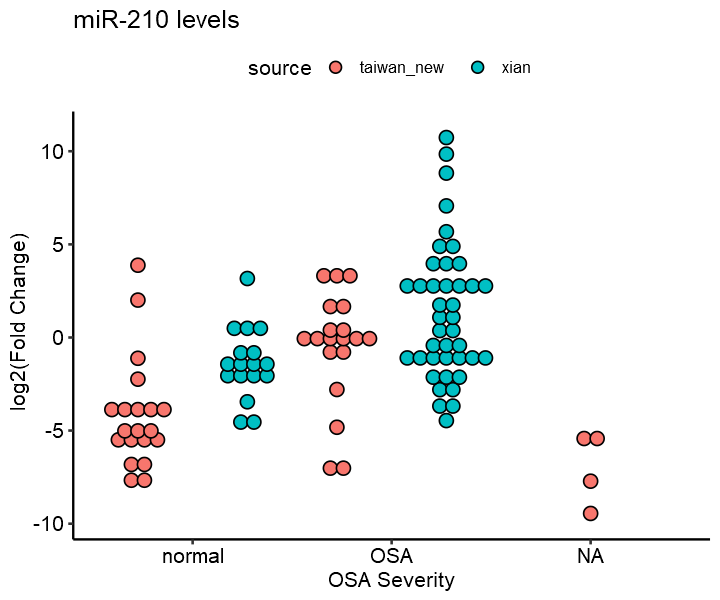

In [26]:
options(repr.plot.width=6, repr.plot.height=5)
dt_melt <- melt(dt[source == "xian" | source == "taiwan_new" ,], id.vars = c("log2_mir210_FC" , "source" ),measure.vars = c("severity"))
dt_melt[value == "mild" | value == "moderate" | value == "severe",]$value <- "OSA"
dt_melt$value <- factor(dt_melt$value, levels= c("normal", "OSA"),labels = c("normal", "OSA"))
p1 <- suppressWarnings(dotplotgraph(dataset = dt_melt, 
                              xaxis = dt_melt$value, 
                              yaxis = dt_melt$log2_mir210_FC, #log2_mir210_FC
                              xlabel = "OSA Severity",
                              ylabel = "log2(Fold Change)",
                              title = "miR-210 levels", 
                              dodge = 1.1, 
                              bin = 0.7));p1
#tiff(file = "./results/1.tiff", width = 1200, height = 750, units = "px", res = 300); p1; dev.off()

#### Identify differences between the taiwan and xian datasets

Since the data are non-parametric, a Mann Whitney U test was used to compute differences between the two data sources for continuous variables:<br>
$$U_{1} = n_{1}n_{2}+\frac{n_{1}(n_{1}+1)}{2}-R1$$
$$U_{2} = n_{1}n_{2}+\frac{n_{1}(n_{1}+1)}{2}-R2$$

In [27]:
k <- intersect(colnames(dt_sub[source == "taiwan_new",purrr::map_lgl(dt_sub, is.numeric), with = FALSE] %>% select_if(~sum(!is.na(.)) > 0)),
               colnames(dt_sub[source == "xian",purrr::map_lgl(dt_sub, is.numeric), with = FALSE] %>% select_if(~sum(!is.na(.)) > 0)))
continuous_compare(DT1 = dt_sub[source == "taiwan_new",purrr::map_lgl(dt_sub, is.numeric), with = FALSE] %>% select_if(~sum(!is.na(.)) > 0),
                   DT2 = dt_sub[source == "xian",purrr::map_lgl(dt_sub, is.numeric), with = FALSE] %>% select_if(~sum(!is.na(.)) > 0)
                   , compair = "Taiwan-Xian", key = k)

comparison,parameter,Mann_Whitney_U_p_value,significant
<chr>,<chr>,<dbl>,<chr>
Taiwan-Xian,cel_mir39_ct,6.966163e-15,TRUE
Taiwan-Xian,mir210_ct,3.014565e-09,TRUE
Taiwan-Xian,delta_ct_210,9.363963e-13,TRUE
Taiwan-Xian,mir210_FC,5.957390e-05,TRUE
Taiwan-Xian,log2_mir210_FC,5.957390e-05,TRUE
Taiwan-Xian,age,3.596837e-08,TRUE
Taiwan-Xian,bmi,2.435224e-02,TRUE
Taiwan-Xian,weight,6.643710e-02,FALSE
Taiwan-Xian,height,1.172383e-01,FALSE


Differences between categorical variables were calculated according to the Chi-squared test:
$$\chi^{2} = \sum_{i=1}^{n}\frac{(O_{i} - E_{i})^{2}} {E_{i}}$$
$$where:$$
O: the observed frequency<br>
E: the expected frequency<br>
$\alpha = 0.05$ : significance cutoff<br>
n-1 degrees of freedom were used to determine the p-value in the significance table.

In [28]:
#### retain only character columns
k <- intersect(colnames(dt_sub[source == "taiwan_new",purrr::map_lgl(dt_sub, is.character), with = FALSE] %>% select_if(~sum(!is.na(.)) > 0)),
               colnames(dt_sub[source == "xian",purrr::map_lgl(dt_sub, is.character), with = FALSE] %>% select_if(~sum(!is.na(.)) > 0)))
k <- k[2:length(k)]
categorical_compare(DT = dt_sub[,k, with = FALSE], compair = "Taiwan-Xian", compair_column = "source", keys = k)

comparison,parameter,Chai_squared_p_value,significant
<chr>,<chr>,<dbl>,<chr>
Taiwan-Xian,source,7.105746e-23,TRUE
Taiwan-Xian,sex,6.025693e-02,FALSE
Taiwan-Xian,obesity,5.965482e-03,TRUE
Taiwan-Xian,severity,7.650273e-03,TRUE
Taiwan-Xian,htn,8.994795e-02,FALSE
Taiwan-Xian,chd,1.000000e+00,FALSE
Taiwan-Xian,dm,7.563724e-04,TRUE
Taiwan-Xian,stroke,1.000000e+00,FALSE
Taiwan-Xian,outcome,1.324822e-02,TRUE


Summary: these analyses indicate that miR210_FC, age, insulin, glucose, t_chol, tg, hdl, ldl, outcome, htn, and dm are all statistically significant parameters that differentiate the taiwan and Xi'an datasets. 

### Identify attributes that are different in people who have OSA compared to those who do not.

#### Xian dataset

In [29]:
dt_sub <- dt[,c(2:33,35:46,65:66)][source == "xian",]
k <- intersect(colnames(dt_sub[osa_group == 'OSA',purrr::map_lgl(dt_sub, is.numeric), with = FALSE] %>% select_if(~sum(!is.na(.)) > 0)),
               colnames(dt_sub[osa_group == 'normal',purrr::map_lgl(dt_sub, is.numeric), with = FALSE] %>% select_if(~sum(!is.na(.)) > 0)))
continuous_compare(DT1 = dt_sub[osa_group == 'OSA',purrr::map_lgl(dt_sub, is.numeric), with = FALSE] %>% select_if(~sum(!is.na(.)) > 0),
                   DT2 = dt_sub[osa_group == 'normal',purrr::map_lgl(dt_sub, is.numeric), with = FALSE] %>% select_if(~sum(!is.na(.)) > 0)
                   , compair = "OSA-normal", key = k)

comparison,parameter,Mann_Whitney_U_p_value,significant
<chr>,<chr>,<dbl>,<chr>
OSA-normal,cel_mir39_ct,6.467881e-02,FALSE
OSA-normal,mir210_ct,5.671044e-01,FALSE
OSA-normal,mir92a_ct,7.780382e-01,FALSE
OSA-normal,mir21_ct,4.319627e-01,FALSE
OSA-normal,delta_ct_210,3.300133e-03,TRUE
OSA-normal,delta_ct_92a,3.715274e-02,TRUE
OSA-normal,delta_ct_21,1.653683e-02,TRUE
OSA-normal,mir210_FC,3.300133e-03,TRUE
OSA-normal,log2_mir210_FC,3.300133e-03,TRUE


#### Taiwan dataset

In [30]:
dt_sub <- dt[,c(2:33,35:46,65:66)][source == "taiwan_new",]
k <- intersect(colnames(dt_sub[osa_group == 'OSA',purrr::map_lgl(dt_sub, is.numeric), with = FALSE] %>% select_if(~sum(!is.na(.)) > 0)),
               colnames(dt_sub[osa_group == 'normal',purrr::map_lgl(dt_sub, is.numeric), with = FALSE] %>% select_if(~sum(!is.na(.)) > 0)))
continuous_compare(DT1 = dt_sub[osa_group == 'OSA',purrr::map_lgl(dt_sub, is.numeric), with = FALSE] %>% select_if(~sum(!is.na(.)) > 0),
                   DT2 = dt_sub[osa_group == 'normal',purrr::map_lgl(dt_sub, is.numeric), with = FALSE] %>% select_if(~sum(!is.na(.)) > 0)
                   , compair = "OSA-normal", key = k)

comparison,parameter,Mann_Whitney_U_p_value,significant
<chr>,<chr>,<dbl>,<chr>
OSA-normal,cel_mir39_ct,5.565637e-05,TRUE
OSA-normal,mir210_ct,7.200785e-02,FALSE
OSA-normal,delta_ct_210,1.473617e-04,TRUE
OSA-normal,mir210_FC,1.473617e-04,TRUE
OSA-normal,log2_mir210_FC,1.473617e-04,TRUE
OSA-normal,age,1.512632e-01,FALSE
OSA-normal,bmi,1.275318e-02,TRUE
OSA-normal,weight,1.884089e-01,FALSE
OSA-normal,height,8.032744e-01,FALSE


#### Xian and Taiwan datasets combined

In [31]:
dt_sub <- dt[,c(2:33,35:46,65:66)][source == "xian" | source == "taiwan_new",]
k <- intersect(colnames(dt_sub[osa_group == 'OSA',purrr::map_lgl(dt_sub, is.numeric), with = FALSE] %>% select_if(~sum(!is.na(.)) > 0)),
               colnames(dt_sub[osa_group == 'normal',purrr::map_lgl(dt_sub, is.numeric), with = FALSE] %>% select_if(~sum(!is.na(.)) > 0)))
(comp <- continuous_compare(DT1 = dt_sub[osa_group == 'OSA',purrr::map_lgl(dt_sub, is.numeric), with = FALSE] %>% select_if(~sum(!is.na(.)) > 0),
                   DT2 = dt_sub[osa_group == 'normal',purrr::map_lgl(dt_sub, is.numeric), with = FALSE] %>% select_if(~sum(!is.na(.)) > 0)
                   , compair = "OSA-normal", key = k))
#writab(comp, fname = "./results/table mannX.xls")

comparison,parameter,Mann_Whitney_U_p_value,significant
<chr>,<chr>,<dbl>,<chr>
OSA-normal,cel_mir39_ct,8.654588e-01,FALSE
OSA-normal,mir210_ct,2.685097e-01,FALSE
OSA-normal,mir92a_ct,7.780382e-01,FALSE
OSA-normal,mir21_ct,4.319627e-01,FALSE
OSA-normal,delta_ct_210,2.979728e-01,FALSE
OSA-normal,delta_ct_92a,3.715274e-02,TRUE
OSA-normal,delta_ct_21,1.653683e-02,TRUE
OSA-normal,mir210_FC,4.955164e-08,TRUE
OSA-normal,log2_mir210_FC,4.955164e-08,TRUE


In [32]:
#### retain only character columns
k <- intersect(colnames(dt_sub[osa_group == 'OSA',purrr::map_lgl(dt_sub, is.character), with = FALSE] %>% select_if(~sum(!is.na(.)) > 0)),
               colnames(dt_sub[osa_group == 'normal',purrr::map_lgl(dt_sub, is.character), with = FALSE] %>% select_if(~sum(!is.na(.)) > 0)))
k <- k[2:length(k)]
comp <- categorical_compare(DT = dt_sub[,k, with = FALSE], compair = "OSA-normal", compair_column = "osa_group", keys = k);comp
#writab(comp, fname = "./results/table chaiX.xls")

comparison,parameter,Chai_squared_p_value,significant
<chr>,<chr>,<dbl>,<chr>
OSA-normal,sex,3.915589e-03,TRUE
OSA-normal,obesity,9.350409e-03,TRUE
OSA-normal,severity,6.024706e-21,TRUE
OSA-normal,osa_group,7.307296e-23,TRUE
OSA-normal,htn,1.880561e-02,TRUE
OSA-normal,chd,5.321398e-01,FALSE
OSA-normal,dm,8.280820e-01,FALSE
OSA-normal,stroke,1.000000e+00,FALSE


## Explore clinical parameters that may be involved in miR210 induction 

#### Use miR210 as the dependent variable and determine what variables can predict miR210 levels.

In [33]:
dt_sub1 <- dt_sub[,outcome :=  log2_mir210_FC][,log2_mir210_FC := NULL]#[source == "xian",]
#colnames(dt_sub1)
k <- 2:length(colnames(dt_sub1))-1
#univariantlmR(dt_sub1, key = k, significant = "F")
univariantlmR(dt_sub1, key = k, significant = "T")
dt_sub <- dt[,c(1:46, 52:64,65:66)][,outcome := osa_group][,osa_group := NULL][source == "xian" | source == "taiwan_new" ,]
#colnames(dt_sub)

  |======================================================================| 100%


Estimate,Std. Error,t value,Pr(>|t|),names,formula,Significance
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
-4.135026e-01,1.149920e-01,-3.595925,5.062154e-04,mir210_ct,outcome ~ mir210_ct,Significant
3.452009e-01,1.542669e-01,2.237687,2.923763e-02,mir92a_ct,outcome ~ mir92a_ct,Significant
1.015931e+02,3.370057e+01,3.014581,3.268810e-03,delta_ct_210,outcome ~ delta_ct_210,Significant
1.925672e+00,5.117206e-01,3.763132,4.037583e-04,delta_ct_92a,outcome ~ delta_ct_92a,Significant
1.104744e+04,2.508536e+03,4.403937,4.841449e-05,delta_ct_21,outcome ~ delta_ct_21,Significant
9.415560e-03,1.747188e-03,5.388980,4.805429e-07,mir210_FC,outcome ~ mir210_FC,Significant
4.667277e-02,1.240264e-02,3.763132,4.037583e-04,mir92_FC,outcome ~ mir92_FC,Significant
6.223838e-01,1.183699e-01,5.257956,2.360663e-06,log2_mir92_FC,outcome ~ log2_mir92_FC,Significant
9.761915e-03,2.216634e-03,4.403937,4.841449e-05,mir21_FC,outcome ~ mir21_FC,Significant


These analyses suggest that age, ahi, insulin, glucose, t_chol, tg, hdl, ldl, htn(Y), dm(Y), cr, afib(Y), log2_ahi, and log2_odi can all predict the serum level of miR210.

#### Indentify attributes that correlate with miR210 as an approach to further define insights into the mechanistic basis for miR210 induction.

Since, in general, the data are not normally distribues, correlations were conducted using the spearman method:<br>
$$\rho = 1-\frac{6\sum d_{i}^{2}}{n(n^{2}-1)}$$

$$where:$$<br>
$\rho$ : Spearman rank correlation <br>
$d_{i}$ : The difference between the ranks of corresponding variables <br>
$n$ : The number of observations <br>

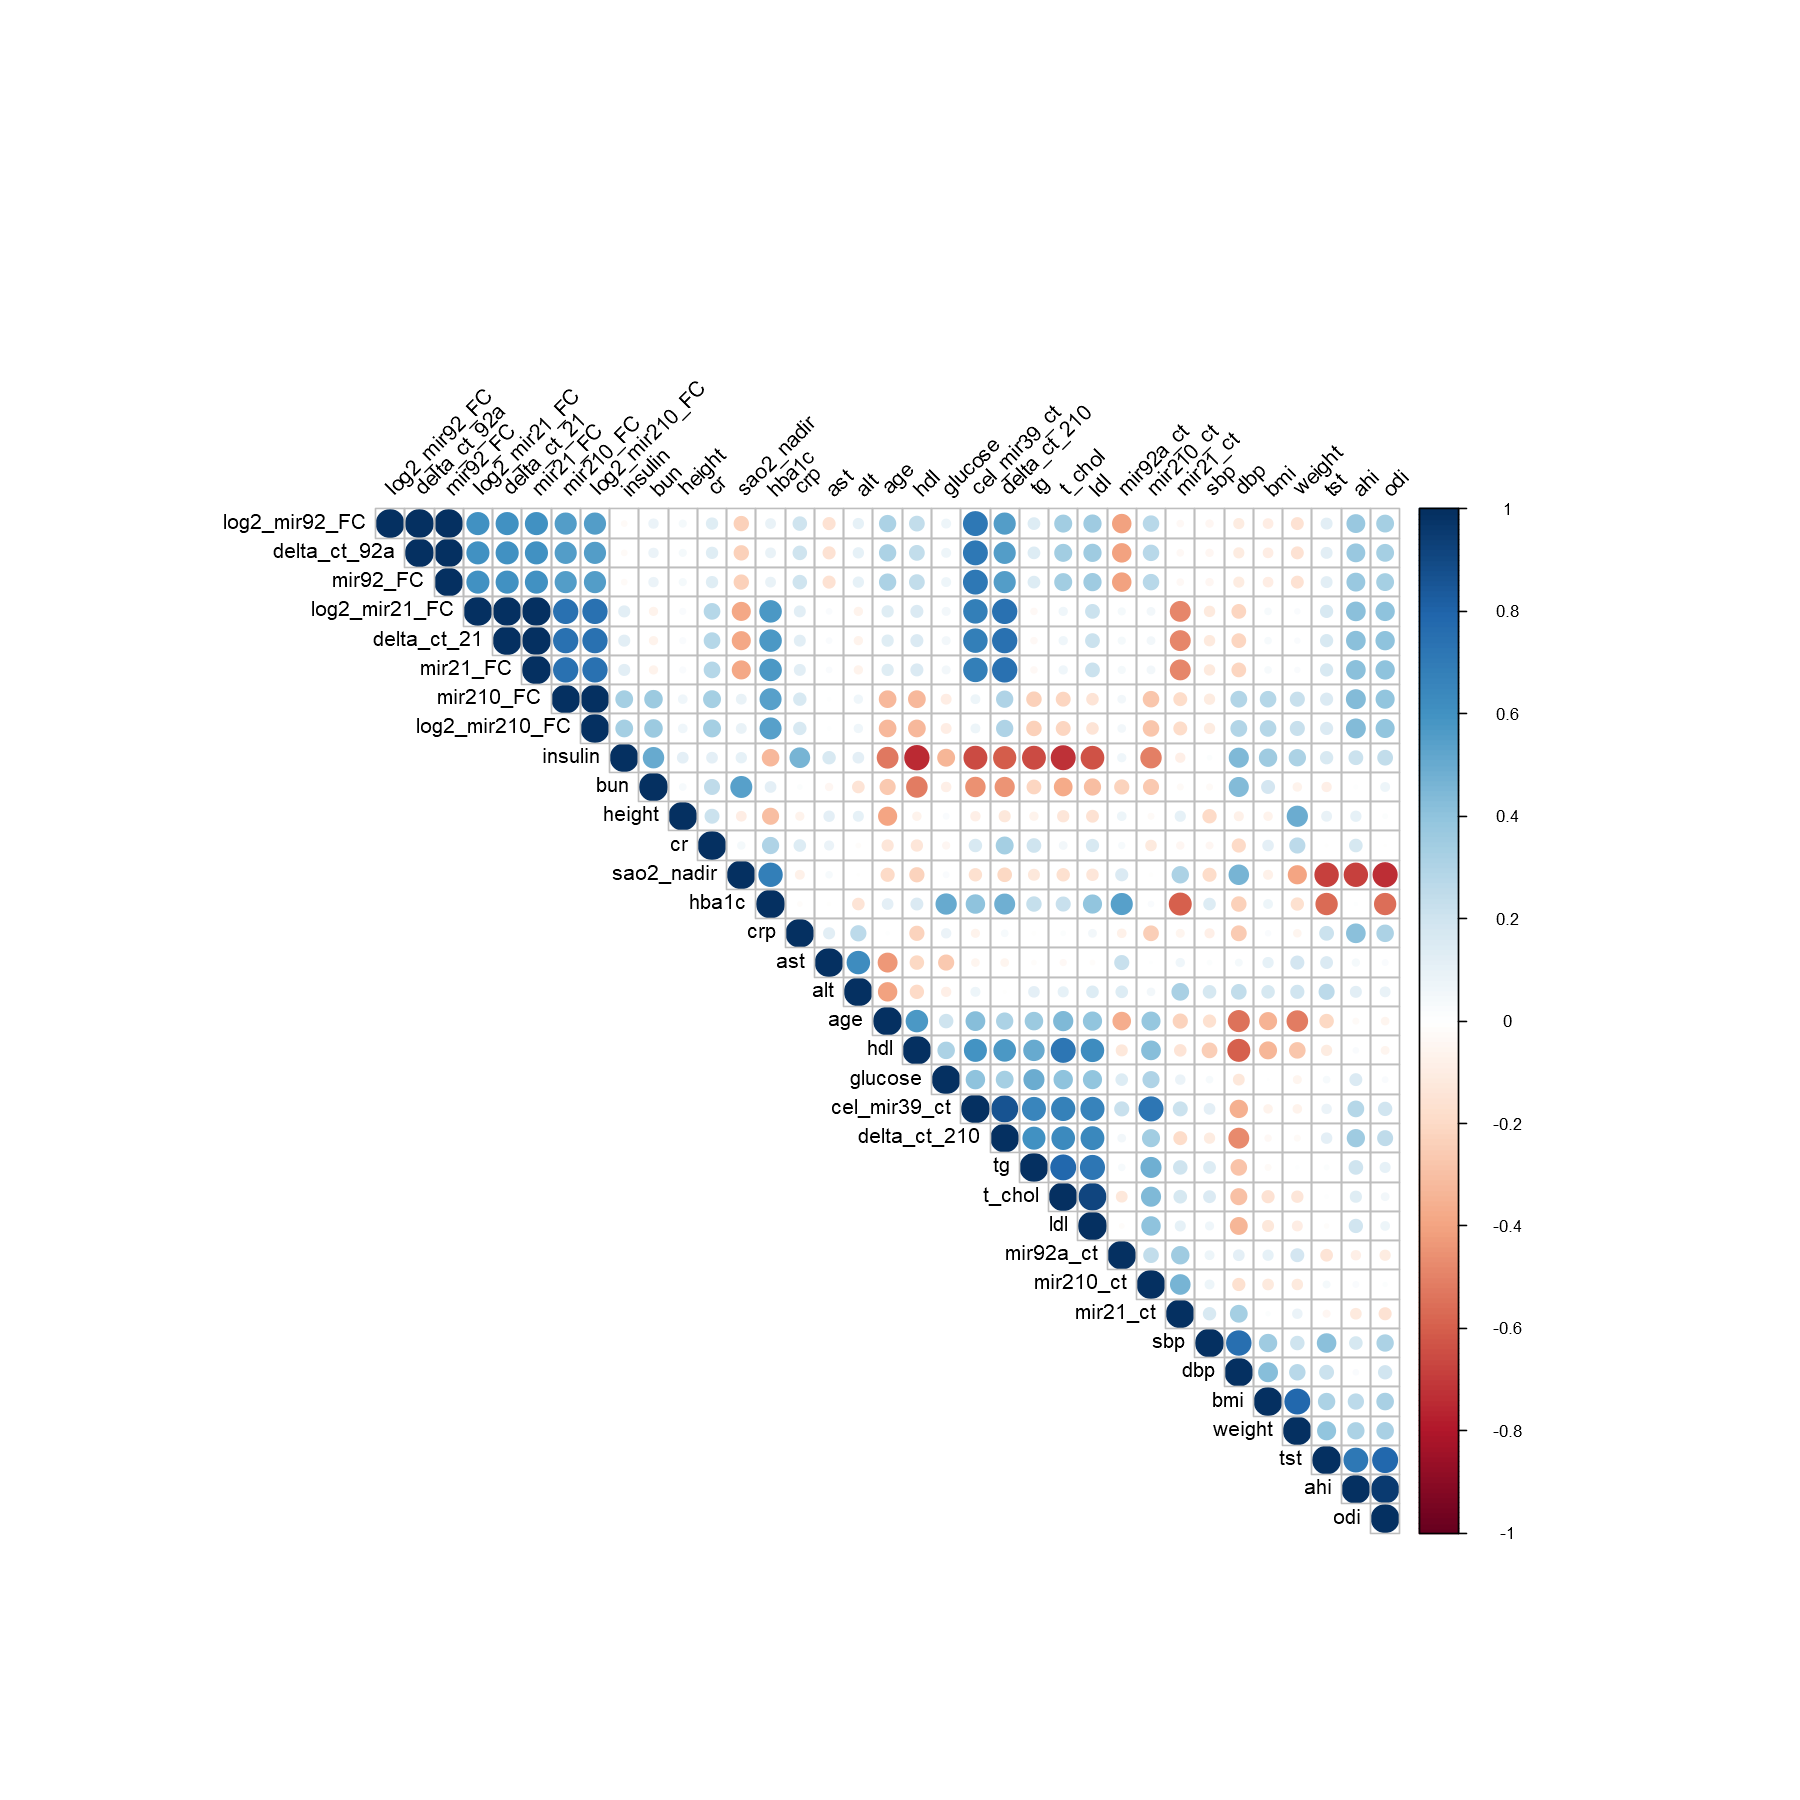

In [34]:
options(repr.plot.width=15, repr.plot.height=15) # type = c("pearson","spearman")
res2 <- rcorr(as.matrix( dt_sub[,purrr::map_lgl(dt_sub, is.numeric), with = FALSE][,c(1:27,29:36)] %>% select_if(~sum(!is.na(.)) > 0) ),type = c("spearman"))
corrplot(res2$r, type = "upper", order = "hclust", tl.col = "black", tl.srt = 45)

#### Identify the attributes that have a significant correlation (p<0.05) with miR210

In [35]:
flat <- flattenCorrMatrix(res2$r, res2$P);flat <- flat[order(abs(flat$cor), decreasing = TRUE),]
fl210 <- flat[grep("log2_mir210", flat$row, ignore.case = TRUE),]; fl210[fl210$p < 0.05,]

,row,column,cor,p
,<fct>,<fct>,<dbl>,<dbl>
64,log2_mir210_FC,mir21_FC,0.7430285,2.411693e-11
75,log2_mir210_FC,log2_mir21_FC,0.7430285,2.411693e-11
45,log2_mir210_FC,mir92_FC,0.5503738,7.611747e-06
54,log2_mir210_FC,log2_mir92_FC,0.5503738,7.611747e-06
505,log2_mir210_FC,hba1c,0.5422680,9.128542e-03
145,log2_mir210_FC,ahi,0.4330193,4.839386e-05
360,log2_mir210_FC,odi,0.3908980,8.972236e-04
537,log2_mir210_FC,bun,0.3646293,1.516136e-03
570,log2_mir210_FC,cr,0.3376813,9.532125e-03


These analyses suggest that ldl, t_chol, tg, hdl, insulin, hba1c, ahi, cr, glucose, odi, and age all correlate with serum miR210 abundance.

#### Plot correlations

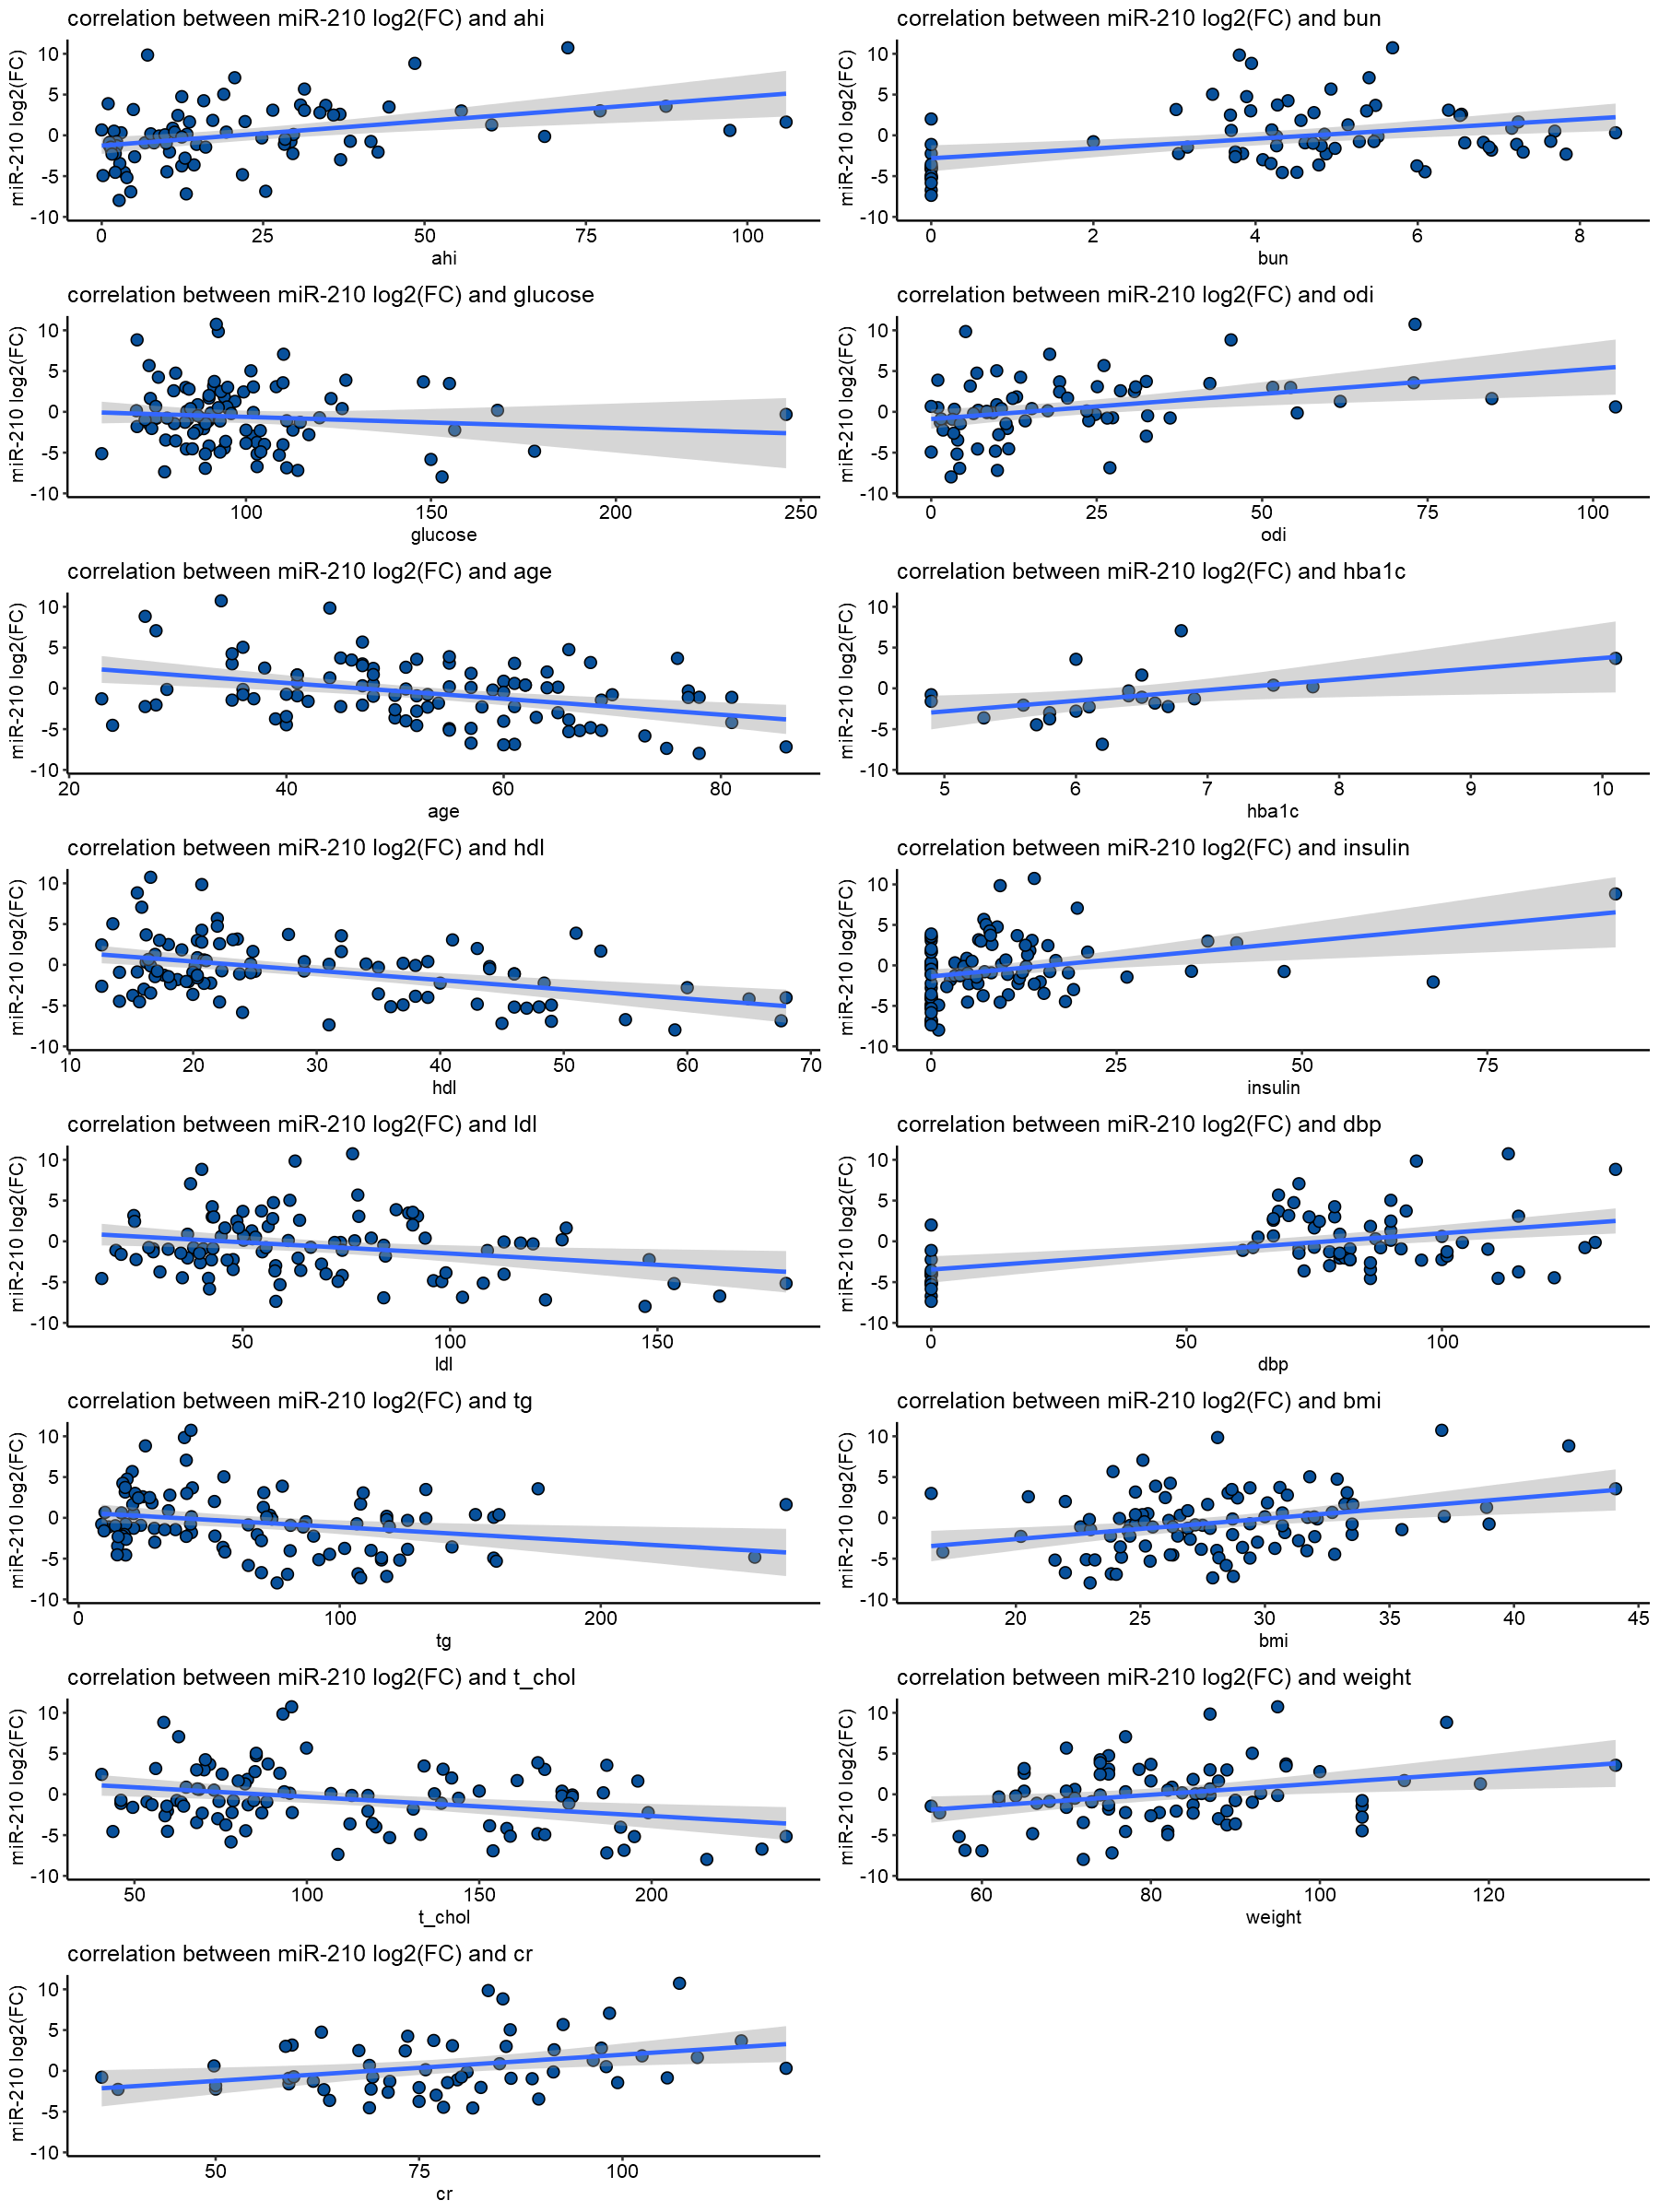

In [36]:
options(repr.plot.width=15, repr.plot.height=20)
p1 <- scatterplotgraph(dataset =dt_sub, #
                 xaxis = dt_sub$ahi, 
                 yaxis = dt_sub$log2_mir210_FC, 
                 xlabel = "ahi",
                 ylabel = "miR-210 log2(FC)",
                 title = "correlation between miR-210 log2(FC) and ahi")
p2 <- scatterplotgraph(dataset =dt_sub, 
                 xaxis = dt_sub$glucose, 
                 yaxis = dt_sub$log2_mir210_FC,
                 xlabel = "glucose",
                 ylabel = "miR-210 log2(FC)",
                 title = "correlation between miR-210 log2(FC) and glucose")
p3 <- scatterplotgraph(dataset = dt_sub, 
                 xaxis = dt_sub$age, 
                 yaxis = dt_sub$log2_mir210_FC, 
                 xlabel = "age",
                 ylabel = "miR-210 log2(FC)",
                 title = "correlation between miR-210 log2(FC) and age")
p4 <- scatterplotgraph(dataset = dt_sub, 
                 xaxis = dt_sub$hdl, 
                 yaxis = dt_sub$log2_mir210_FC, 
                 xlabel = "hdl",
                 ylabel = "miR-210 log2(FC)",
                 title = "correlation between miR-210 log2(FC) and hdl")
p5 <- scatterplotgraph(dataset = dt_sub, 
                 xaxis = dt_sub$ldl, 
                 yaxis = dt_sub$log2_mir210_FC, 
                 xlabel = "ldl",
                 ylabel = "miR-210 log2(FC)",
                 title = "correlation between miR-210 log2(FC) and ldl")
p6 <- scatterplotgraph(dataset = dt_sub, 
                 xaxis = dt_sub$tg, 
                 yaxis = dt_sub$log2_mir210_FC, 
                 xlabel = "tg",
                 ylabel = "miR-210 log2(FC)",
                 title = "correlation between miR-210 log2(FC) and tg")
p7 <- scatterplotgraph(dataset = dt_sub, 
                 xaxis = dt_sub$t_chol, 
                 yaxis = dt_sub$log2_mir210_FC, 
                 xlabel = "t_chol",
                 ylabel = "miR-210 log2(FC)",
                 title = "correlation between miR-210 log2(FC) and t_chol")
p8 <- scatterplotgraph(dataset = dt_sub, 
                 xaxis = dt_sub$cr, 
                 yaxis = dt_sub$log2_mir210_FC, 
                 xlabel = "cr",
                 ylabel = "miR-210 log2(FC)",
                 title = "correlation between miR-210 log2(FC) and cr")
p9 <- scatterplotgraph(dataset = dt_sub, 
                 xaxis = dt_sub$bun, 
                 yaxis = dt_sub$log2_mir210_FC, 
                 xlabel = "bun",
                 ylabel = "miR-210 log2(FC)",
                 title = "correlation between miR-210 log2(FC) and bun")
p10 <- scatterplotgraph(dataset = dt_sub, 
                 xaxis = dt_sub$odi, 
                 yaxis = dt_sub$log2_mir210_FC, 
                 xlabel = "odi",
                 ylabel = "miR-210 log2(FC)",
                 title = "correlation between miR-210 log2(FC) and odi")
p11 <- scatterplotgraph(dataset = dt_sub, 
                 xaxis = dt_sub$hba1c, 
                 yaxis = dt_sub$log2_mir210_FC, 
                 xlabel = "hba1c",
                 ylabel = "miR-210 log2(FC)",
                 title = "correlation between miR-210 log2(FC) and hba1c")
p12 <- scatterplotgraph(dataset = dt_sub, 
                 xaxis = dt_sub$insulin, 
                 yaxis = dt_sub$log2_mir210_FC, 
                 xlabel = "insulin",
                 ylabel = "miR-210 log2(FC)",
                 title = "correlation between miR-210 log2(FC) and insulin")
p13 <- scatterplotgraph(dataset = dt_sub, 
                 xaxis = dt_sub$dbp, 
                 yaxis = dt_sub$log2_mir210_FC, 
                 xlabel = "dbp",
                 ylabel = "miR-210 log2(FC)",
                 title = "correlation between miR-210 log2(FC) and dbp")
p14 <- scatterplotgraph(dataset = dt_sub, 
                 xaxis = dt_sub$bmi, 
                 yaxis = dt_sub$log2_mir210_FC, 
                 xlabel = "bmi",
                 ylabel = "miR-210 log2(FC)",
                 title = "correlation between miR-210 log2(FC) and bmi")
p15 <- scatterplotgraph(dataset = dt_sub, 
                 xaxis = dt_sub$weight, 
                 yaxis = dt_sub$log2_mir210_FC, 
                 xlabel = "weight",
                 ylabel = "miR-210 log2(FC)",
                 title = "correlation between miR-210 log2(FC) and weight")
suppressWarnings(multiplot(p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15, cols = 2))

#### Generate an overall plot of the correlation analysis.

In [37]:
fl210 <- data.table(fl210)
fl210[,sig:= ifelse(fl210$p<0.05,"Y","N")]
fl210[order(fl210$p),]

row,column,cor,p,sig
<fct>,<fct>,<dbl>,<dbl>,<chr>
log2_mir210_FC,mir21_FC,0.743028533,2.411693e-11,Y
log2_mir210_FC,log2_mir21_FC,0.743028533,2.411693e-11,Y
log2_mir210_FC,mir92_FC,0.550373766,7.611747e-06,Y
log2_mir210_FC,log2_mir92_FC,0.550373766,7.611747e-06,Y
log2_mir210_FC,ahi,0.433019315,4.839386e-05,Y
log2_mir210_FC,odi,0.390898046,8.972236e-04,Y
log2_mir210_FC,insulin,0.330841907,9.332852e-04,Y
log2_mir210_FC,hdl,-0.329452069,1.046621e-03,Y
log2_mir210_FC,age,-0.325809433,1.127580e-03,Y


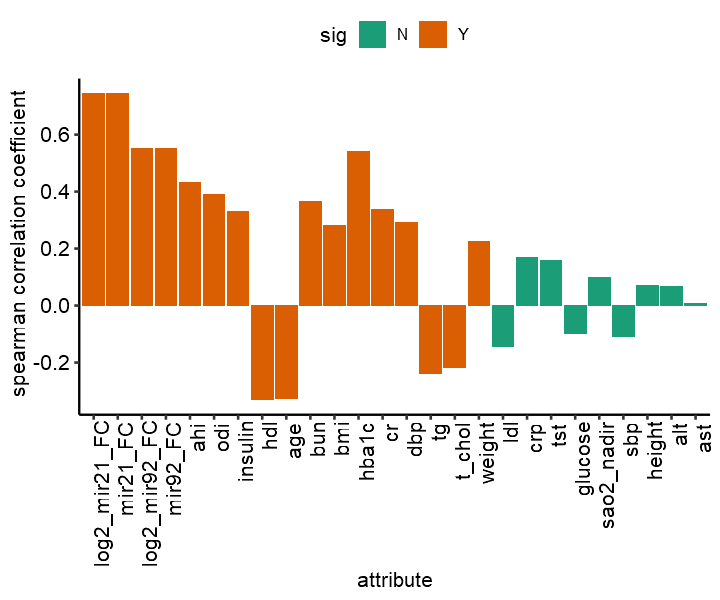

In [38]:
options(repr.plot.width=6, repr.plot.height=5)
g1 <- ggplot(fl210, aes(x = reorder(column, p) , y = cor, fill=sig)) + #[order(fl210$p),]
   geom_bar(stat = "identity")+ #, fill='#08306B'
   scale_fill_brewer(palette="Dark2")+
   theme_pubr()+
   theme(axis.text.x = element_text(angle = 90, hjust = 1))+
   xlab("attribute")+ylab("spearman correlation coefficient"); g1
#tiff(file = "./results/1.tiff", width = 1000, height = 500, units = "px", res = 100);g1;dev.off()

These results suggest that the serum levels of miR210 correlate with t_chol, tg, ldl, hdl, age, hba1c, odi, and ahi.

#### Final section summary:
These analyses suggest that age, ahi, insulin, glucose, t_chol, tg, hdl, ldl, htn(Y), dm(Y), cr, afib(Y), log2_ahi, and log2_odi can all predict the serum level of miR210.<br>

ldl, t_chol, tg, hdl, insulin, hba1c, ahi, cr, glucose, odi, and age all correlate with serum miR210 abundance.

## Analytical matching between identified clinical parameters and Transcription factor gene ontology

This section computes the term frequence inverse document frequency (TF-IDF) for clinical serum markers that predict the serum level of miR210 (age, insulin, glucose, cholesterol, triglyceride, lipoprotein) as well as gene ontology information that describes the activation characteristics for each transcription factor. TF-IDF is computed as follows:
$$TFIDF(t,d)=TF(t,d) X log(\frac{N}{DF(t))})$$
t: term (word in document) <br>
d: document <br>
TF(t): term frequency (number of times the term t appears in document <br>
N: number of documents in corpus <br>
DF(t): number of documents in the corpus containing the term t <br>
<br>
The weighted cosine simularity score (dot product) is then computed to determine the transcription factors that whose activity is likely to be modulated by the identified serum markers. <br>

$$S(Q,D) = \frac{\sum_{}^{} Q_{w}D_{w}}{\sqrt{\sum_{}^{} Q_{w}^{2}} X \sqrt{\sum_{}^{} D_{w}^{2}}}$$
<br>
$$where:$$ <br>
$$Q_{w} = \frac{tf_{wQ}} {tf_{wQ}+\frac{k\left | Q \right |}{ave\left | Q \right |}} X log(\frac{\left | C \right |}{df_{w}})$$ <br>
$$D_{w} = \frac{tf_{wD}} {tf_{wD}+\frac{k\left | D \right |}{ave\left | D \right |}} X log(\frac{\left | C \right |}{df_{w}})$$

### Compile transcription factor GO term corpus

#### Load and annotate a data table housing transcription factor binding site information

In [39]:
setwd("C:/Users/breng/Dropbox/Brendan Documents/programming/scripts/transcription factor consensus sequence")
TXDT <- fread("2019-3-22 TX factor data table for R BG.csv", header = TRUE); setwd(homedir)
TXDT <- TXDT[,.(prot, `MotifMap Degenerate consensus sequence`)]
TXDT$prot <- toupper(TXDT$prot)
TXDT$Consensus_Sequence_Medium <- IUPAC_Boolean(TXDT$`MotifMap Degenerate consensus sequence`, stringency = "medium")
setnames(TXDT, c("prot", "MotifMap Degenerate consensus sequence", "Consensus_Sequence_Medium"),
          c("Targeting_Factor", "MotifMap Degenerate consensus sequence", "Consensus_Sequence"))
head(TXDT, 1)

Targeting_Factor,MotifMap Degenerate consensus sequence,Consensus_Sequence
<chr>,<chr>,<chr>
AHR,SYYCNRNSTNGCGTGNSW,(G|C)(C|T)(C|T)C.(A|G).(G|C)T.GCGTG.(G|C)(A|T)


#### Download GO term information for transcription factors and format into a single column

In [40]:
name <- TXDT$Targeting_Factor
go <- BioMartR(value = name, 
               mart = "ENSEMBL_MART_ENSEMBL", 
               species = "hsapiens_gene_ensembl", 
               attribute = c("wikigene_name", "go_id", "name_1006", "definition_1006"),
               filter_by = 'wikigene_name')
go <- data.table(go)
go <- go[(go$wikigene_name %in% name),][,new:=paste0(.SD,collapse=" "),by=seq_along(wikigene_name)][,c("go_id", "name_1006", "definition_1006") := NULL]
head(go, 5)

wikigene_name,new
<chr>,<chr>
AHR,
AHR,"GO:0006355 regulation of transcription, DNA-templated Any process that modulates the frequency, rate or extent of cellular DNA-templated transcription."
AHR,GO:0005515 protein binding Interacting selectively and non-covalently with any protein or protein complex (a complex of two or more proteins that may include other nonprotein molecules).
AHR,"GO:0003700 DNA-binding transcription factor activity A protein or a member of a complex that interacts selectively and non-covalently with a specific DNA sequence (sometimes referred to as a motif) within the regulatory region of a gene to modulate transcription. Regulatory regions include promoters (proximal and distal) and enhancers. Genes are transcriptional units, and include bacterial operons."
AHR,"GO:0046983 protein dimerization activity The formation of a protein dimer, a macromolecular structure consists of two noncovalently associated identical or nonidentical subunits."


#### Write GO information for each gene into individual text files so that they can be incorporated into a corpus in python

In [41]:
#dir.create("newcorpus")
txname <- go[!duplicated(go$wikigene_name),]$wikigene_name
for(i in 1:length(txname)){
def <- paste(go[wikigene_name == txname[i]]$new, collapse = " ")
nam <- paste(txname[i], "\n", collapse = "")
def <- paste(nam, def, collapse = " ")#
fnam <- paste("./newcorpus/", i, "_", txname[i], ".txt", collapse = ""); fnam <- gsub(" ", "", fnam)#; fnam
writab(def, fname = fnam)
    }

#### Compute TF-IDF for the GO terms of each transcription factor, the cosine distances between the clinical terms that predice miR210 levels and each transcription factor corpus, and return a data table of the transcription factors that are most likely to be activated by OSA serum. <br>
Returns the top 20 hits

In [42]:
#"age insulin glucose cholesterol triglyceride lipoprotein ahi odi"
sim <- TFIDFgenescore(directory = 'newcorpus/', terms = "age insulin glucose cholesterol triglyceride lipoprotein ahi odi bun creatnineblood pressure weight")
sim <- data.table(sim); sim[,thresh:= ifelse(cosine_similarity>0.021,"Y","N")];sim

Gene_Name,cosine_similarity,thresh
<chr>,<dbl>,<chr>
NR1H2,0.072255484,Y
SREBF2,0.053007886,Y
USF1,0.043419056,Y
SREBF1,0.041434022,Y
HNF1A,0.039425756,Y
FOXA2,0.037491099,Y
NFE2L1,0.037152573,Y
PDX1,0.036927490,Y
PPARG,0.036698666,Y


#### Graph cosine similarity score

png 
  2

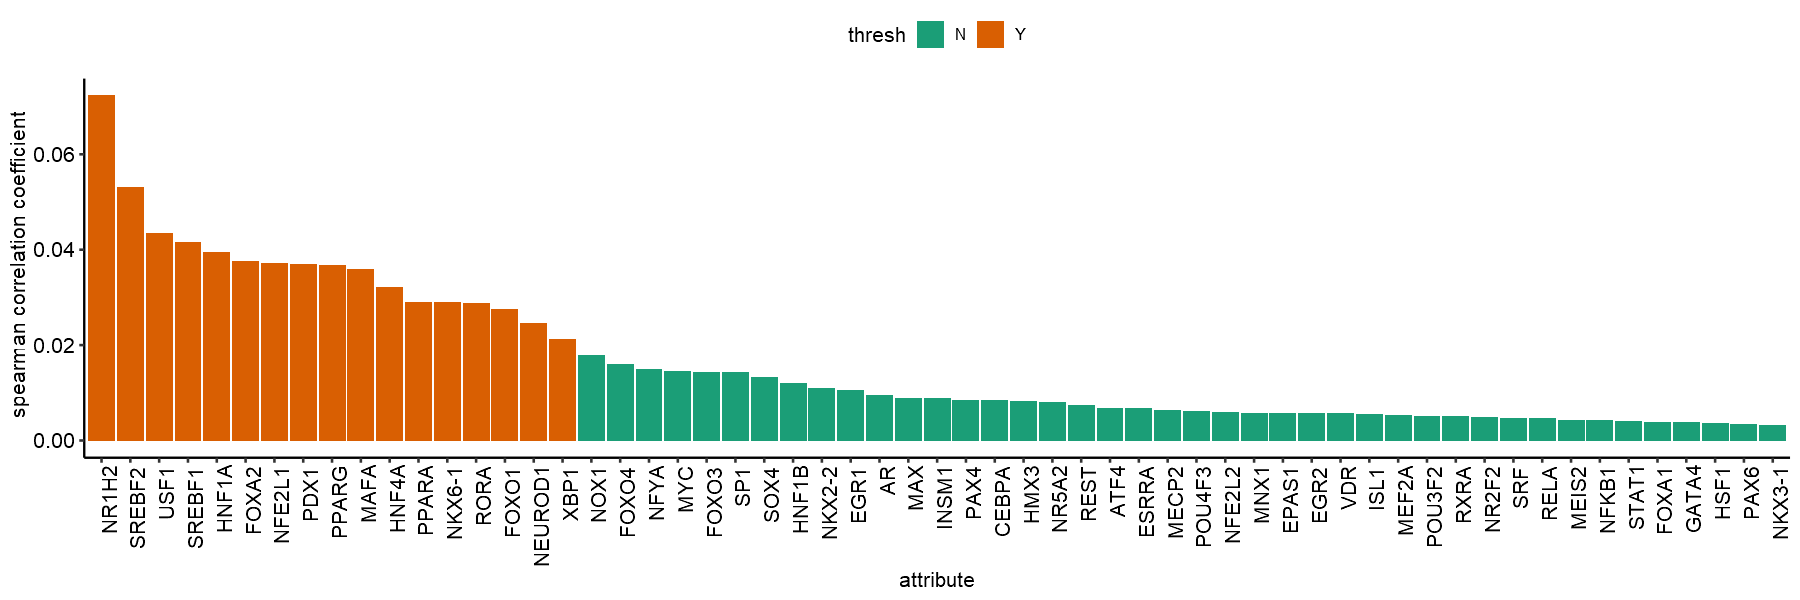

In [43]:
options(repr.plot.width=15, repr.plot.height=5)
g1 <- ggplot(sim, aes(x = reorder(Gene_Name, -cosine_similarity) , y = cosine_similarity, fill=thresh)) + #[order(fl210$p),]
   geom_bar(stat = "identity")+ #, fill='#08306B'
   scale_fill_brewer(palette="Dark2")+
   theme_pubr()+
   theme(axis.text.x = element_text(angle = 90, hjust = 1))+
   xlab("attribute")+ylab("spearman correlation coefficient"); g1
tiff(file = "./results/1.tiff", width = 1300, height = 500, units = "px", res = 100);g1;dev.off()

## Motif enrichment in genes differentially regulated in ECs treated with serum isolated from individuals with OSA compared to serum isolated from healthy control individuals.

#### load genes that are significantly differentially regulated in HUVECs treated with serum isolated from people with OSA
In this RNAseq analysis was conducted via aligning the reads to the genome with hisat2 and determining defferential gene expression with edgeR. 

In [44]:
dt <- fread(osaseq)[,c(3:5,8)][`OSA-CTRL_PValue` < 0.05]

#### Obtain transcription start sites and transcript information from biomart

In [45]:
name <- dt$wikigene_name
go <- BioMartR(value = name, 
               mart = "ENSEMBL_MART_ENSEMBL", 
               species = "hsapiens_gene_ensembl", 
               attribute = c("wikigene_name", "wikigene_description", "transcription_start_site", "chromosome_name", "strand"),
               filter_by = 'wikigene_name')
head(go, 1)
#writab(go, fname = './data/GO BioMart annotations.xls')

wikigene_name,wikigene_description,transcription_start_site,chromosome_name,strand
<chr>,<chr>,<int>,<chr>,<int>
ACKR3,atypical chemokine receptor 3,236567787,2,1


#### Obtain promoter sequences and format into a .fasta file to perform a motif enrichment analysis on

In [46]:
go <-fread('./data/GO BioMart annotations.xls')
TRANS_CHR <- go[!duplicated(go$wikigene_name),]
# Remove erroneous chromosome labels
CHR_Labels <- c(1:21, "X", "Y"); TRANS_CHR <- TRANS_CHR[(TRANS_CHR$chromosome_name %in% CHR_Labels),]
# Relabel chromosome designations for use with the getSeq Function.
TRANS_CHR <- ChromLabel(TRANS_CHR)
# Load available genomes 
ToLoad <- c("Hsapiens.UCSC.hg38"); GenomeLoader(ToLoad)
# return the promoter sequences for the identified transcripts from each Species
genomehum <- BSgenome.Hsapiens.UCSC.hg38
distance <- 2000
SurfTrans <- TRANS_CHR
STA <- SurfTrans$transcription_start_site - distance
END <- SurfTrans$transcription_start_site + distance
CHR <- SurfTrans$chromosome_name
seqs <- getSeq(genomehum, CHR, start = STA, end = END)
#### write fasta file ####
#write.fasta(do.call(c, seqs), names = names(seqs), file.out = "./data/OSA_significant.fasta", open = "w", nbchar = 4001, as.string = FALSE)

#### Perform Motif discovery with BCRANK

In [49]:
set.seed(0)
BCRANKout <- bcrank("./data/OSA_significant.fasta", restarts = 25, use.P1 = TRUE, use.P2 = TRUE)
toptable(BCRANKout)
motiftable <- data.table(toptable(BCRANKout))
#writab(motiftable, fname = "./results/14 identified motifs.xls")

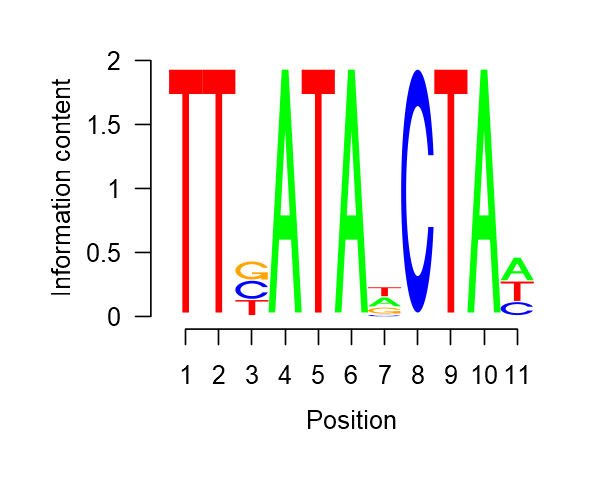

In [48]:
options(repr.plot.width=5, repr.plot.height=4)
#### graph top motif ####
topMotif <- toptable(BCRANKout, 1)
# weightMatrix <- pwm(topMotif, normalize = FALSE)
weightMatrixNormalized <- pwm(topMotif, normalize = TRUE)
seqLogo(weightMatrixNormalized)
#### save seq logos ####
#dir.create("./results/motifs")
for(i in 1:nrow(toptable(BCRANKout))){
  topMotif <- toptable(BCRANKout, i)
  # weightMatrix <- pwm(topMotif, normalize = FALSE)
  weightMatrixNormalized <- pwm(topMotif, normalize = TRUE)
  pdf(paste0("./results/motifs/seqlogo", i, ".pdf", collapse = ""))
  seqLogo(weightMatrixNormalized)
  dev.off()
}

#### Reformat identified motifs into a JASPAR format and save as .JASPAR files to integrate into python libraries

In [ ]:
dir.create("./results/JASPAR_motifs")
Organ <- "Homo_Sapiens"
for(i in 1:nrow(toptable(BCRANKout))){
  topMotif <- toptable(BCRANKout, i)
  weightMatrix <- pwm(topMotif, normalize = FALSE)
  
  BASEID <- paste("TR", i, sep="")
  name <- paste("ID_MOTIF", i, sep="")
  CLASS <- "unknown"
  fname <- paste("./results/JASPAR_motifs/ID_MOTIF", i, sep="")
  
  PARAM <-
    list(
      INT_ID=NULL,
      BASE_ID=BASEID,
      #COLLECTION="CORE",
      VERSION=1,
      NAME=name,
      SPECIES=Organ)
  TAG <-
    list(
      class=CLASS,
      medline="7592839",
      tax_group="vertebrate",
      sysgroup="vertebrate",
      acc="P30561",
      acc="P53762"#,
      #comment="dimer",
      #type="SELEX",
      #newest=1
    )
  cat(make_template(x=weightMatrix,PARAM=PARAM,TAG=TAG, outFpre = fname))
}

#### Open python libraries and match identified motifs to transcription factor motifs.

In [50]:
MOTIF_files <- JASPAR_matrix_import(directory="./results/JASPAR_motifs")

In [51]:
temp_df <- motifannot(jspmotifdb = "./data/JASPAR2020_CORE_vertebrates_non-redundant_pfms_jaspar", 
                      jspmotifdbopen = "./data/JASPAR2020_CORE_vertebrates_non-redundant_pfms_jaspar/", 
                      MOTIF_files = MOTIF_files, 
                      motif_dir = "./results/JASPAR_motifs/")
temp_df[grep("SRE", temp_df$comparison_name),]
#writab(temp_df, fname = './results/15 motif matches.xls')

,index,query name,offset,distance,PCC,comparison_name
,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
59,198,ID_MOTIF14_TR14.1,-9,0.04104671,0.9589533,SREBF1_MA0595.1


In [52]:
temp_df <- revcompmotifannot(jspmotifdb = "./data/JASPAR2020_CORE_vertebrates_non-redundant_pfms_jaspar", 
                             jspmotifdbopen = "./data/JASPAR2020_CORE_vertebrates_non-redundant_pfms_jaspar/", 
                             MOTIF_files = MOTIF_files, 
                             motif_dir = "./results/JASPAR_motifs/")
temp_df[grep("SRE", temp_df$comparison_name),]
#writab(temp_df, fname = './results/16 revcomp motif matches.xls')

,index,query name,offset,distance,PCC,comparison_name
,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
54,198,ID_MOTIF14_TR14.1,-9,0.006063101,0.9939369,SREBF1_MA0595.1
59,199,ID_MOTIF14_TR14.1,-9,0.014448938,0.9855511,SREBF2_MA0596.1


## miR210 promoter transcription factor enrichment and analysis of chromatin remodeling.
This analysis uses HiF1a CHiPseq data (GSE89836) and SREBP2 overexpression ATACseq data collected from HUVECs that I previously analyzed and integrated it with the ENCODE database (GSE35583, GSE29611) of epigenetic modification in histones in the genomic locations flanking the miR210 promoter. GEO dataset websites:<br>
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE35583 <br>
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE29611 <br>
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi <br>
Read sequences were aligned to the genome with hisat2, and bam files were converted to bigwig files.

#### obtain miR210 transcription start site information

#### Format miR genomic location information

miR transcription start site information was obtained from: http://mirstart.mbc.nctu.edu.tw/browse.php

In [53]:
miDT <- fread("./data/2018-1-19 miRstart miRNA transcription start sites.csv")
setnames(miDT, colnames(miDT), c("ID",  "Accession",  "Genomic location", "Type", "TSS", "Cluster"))
#### split the Genomic location into three columns ####
GL <- miDT$`Genomic location`
GL <- gsub(":", "", GL, fixed = TRUE)
GL <- gsub("[", "", GL, fixed = TRUE)
GL <- gsub("]", "", GL, fixed = TRUE)
chromosome_name <- NULL
transcription_start_site <- NULL
Strand <- NULL
for(i in 1: length(GL)){
  spl <- strsplit(GL[i], split = " ")
  chromosome_name[i] <- spl[[1]][1]
  transcription_start_site[i] <- spl[[1]][2]
  Strand[i] <- spl[[1]][3]
}
miDT <- cbind(miDT, data.table(chromosome_name, transcription_start_site, Strand))
#### adjust data.table to download sequence data
miDT$Scientific_Name <- "Homo_sapiens"
miDT$transcription_start_site <- as.numeric(miDT$transcription_start_site)
miDT$chromosome_name <- gsub("Chr", "chr", miDT$chromosome_name, fixed = TRUE)
miDT <- miDT[grepl("mir-210", miDT$ID, ignore.case = TRUE),]; miDT # subset out miR-210

ID,Accession,Genomic location,Type,TSS,Cluster,chromosome_name,transcription_start_site,Strand,Scientific_Name
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
hsa-mir-210,MI0000286,Chr11: 568198 [-],Intergenic,616308(48110),,chr11,568198,-,Homo_sapiens


In [54]:
chr <- as.numeric(gsub("chr", "",miDT$chromosome_name))
start <- miDT$transcription_start_site - 20000
end <- miDT$transcription_start_site + 20000

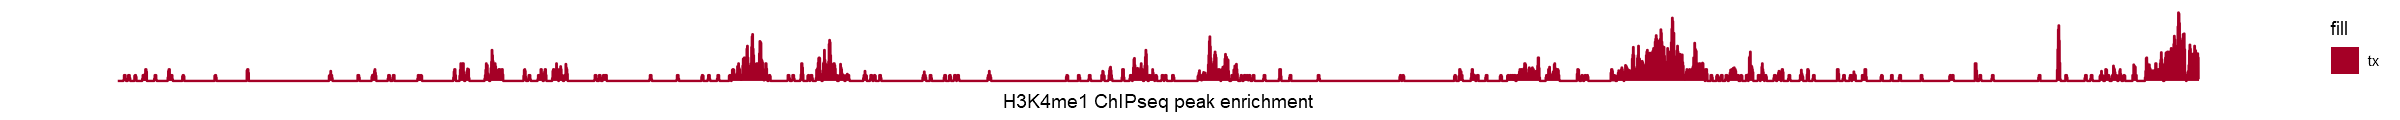

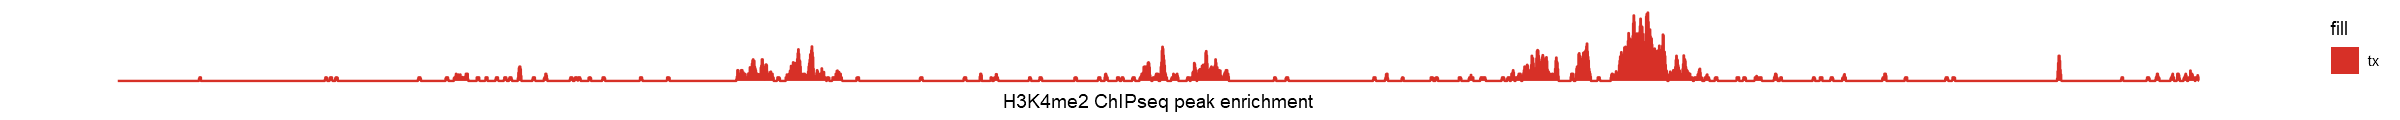

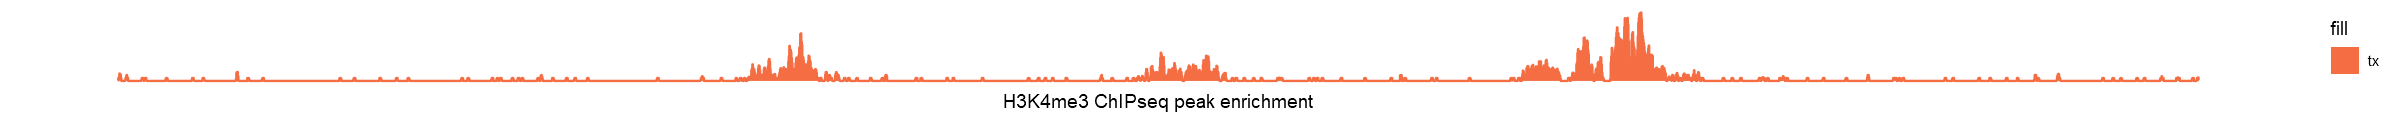

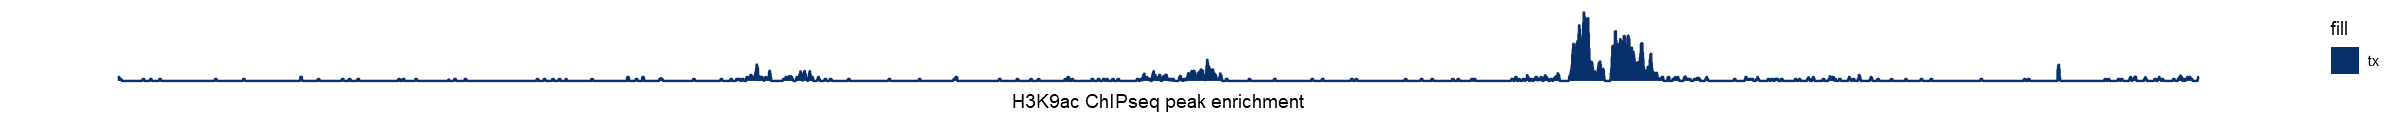

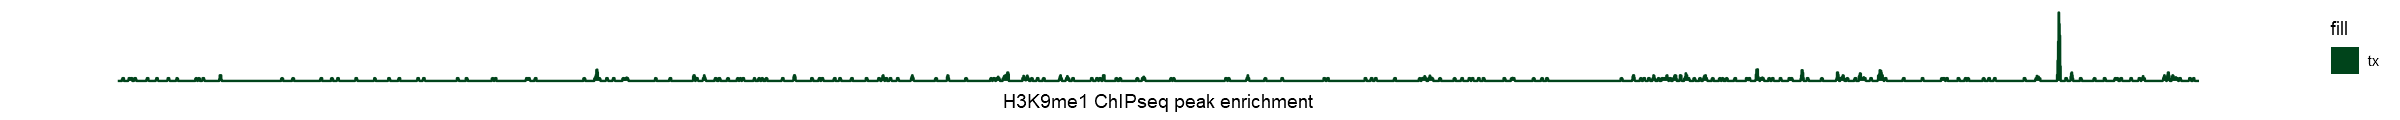

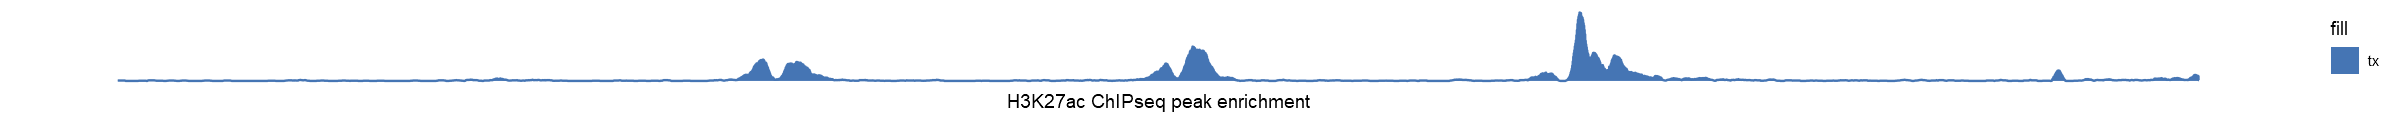

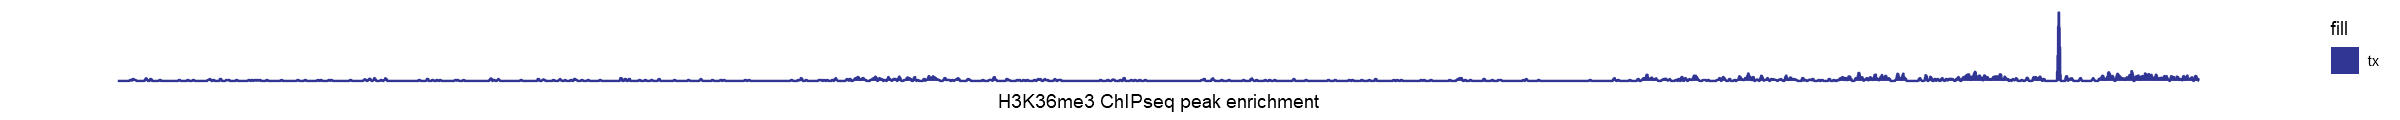

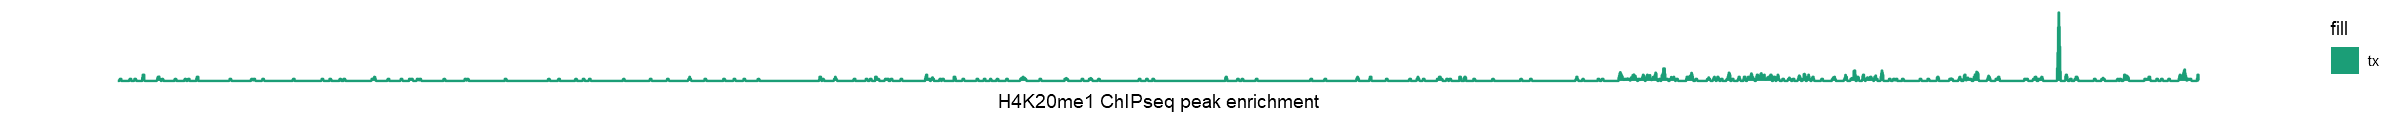

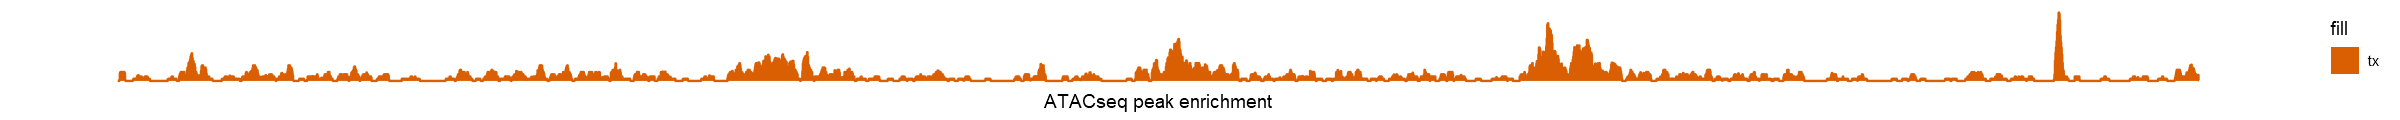

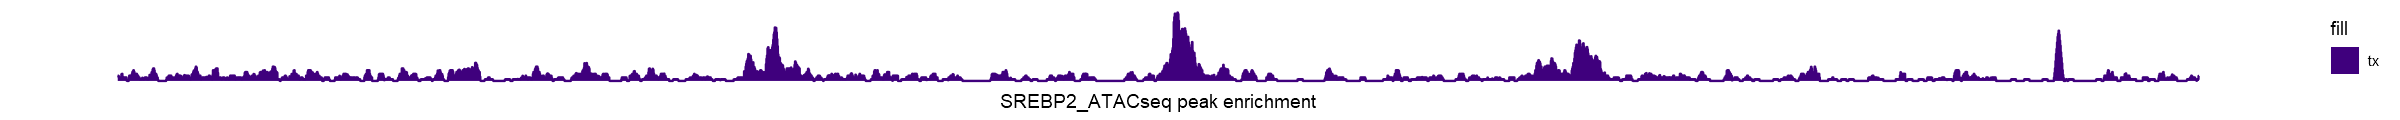

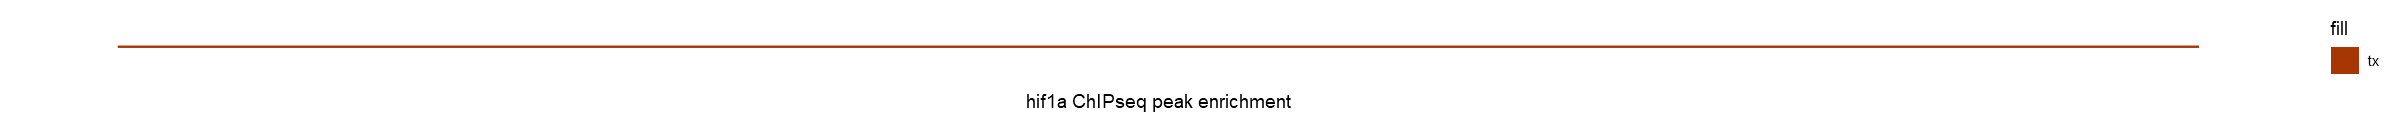

In [55]:
options(repr.plot.width=20, repr.plot.height=1)
bw_filet = c("./data/ChIP_ATAC_files/H3K4me1.bw", "./data/ChIP_ATAC_files/H3K4me2.bw", "./data/ChIP_ATAC_files/H3K4me3.bw", 
            "./data/ChIP_ATAC_files/H3K9ac.bw","./data/ChIP_ATAC_files/H3K9me1.bw", "./data/ChIP_ATAC_files/H3K27ac.bw", 
            "./data/ChIP_ATAC_files/H3K36me3.bw", "./data/ChIP_ATAC_files/H4K20me1.bw", "./data/ChIP_ATAC_files/ATACseq.bw", 
            "./data/ChIP_ATAC_files/SREBP2_ATACseq.bw", "./data/ChIP_ATAC_files/hif1a.bw")
x_labt = c("H3K4me1 ChIPseq peak enrichment", "H3K4me2 ChIPseq peak enrichment", "H3K4me3 ChIPseq peak enrichment",
          "H3K9ac ChIPseq peak enrichment", "H3K9me1 ChIPseq peak enrichment", "H3K27ac ChIPseq peak enrichment",
          "H3K36me3 ChIPseq peak enrichment", "H4K20me1 ChIPseq peak enrichment", "ATACseq peak enrichment",
          "SREBP2_ATACseq peak enrichment", "hif1a ChIPseq peak enrichment")
#cols = c('#A50026', '#D73027', '#F46D43', '#FDAE61', '#ABD9E9', '#74ADD1', '#4575B4', '#313695', '#1B9E77', '#D95F02', '#238B45')
cols = c('#A50026', '#D73027', '#F46D43', '#08306B', '#00441B', '#4575B4', '#313695', '#1B9E77', '#D95F02', '#3F007D', '#A63603')

for(i in 1:length(bw_filet)){

p1 <- ChiPseqPeakPlotter_single(bw_file = bw_filet[i], 
                               chr = chr, 
                               start = start, 
                               end = end, 
                               average_dist = 10, 
                               fill_dist = 10, 
                               type="all",
                               x_lab = x_labt[i],
                               color = cols[i]); print(p1)
tiff(file = paste("./results/", x_labt[i], ".tiff", sep=""), width = 10000, height = 500, units = "px", res = 300); print(p1); dev.off()
}

# Identify the location of SREBP2 binding sites in the miR210 promoter

#### Download the miR210 promoter sequence

In [56]:
ToLoad <- c("Hsapiens.UCSC.hg38"); GenomeLoader(ToLoad) # Load available genomes
genome <- c("Hsapiens.UCSC.hg38")
PROMTrans <- ChromosomeSeqCompileR(DT = miDT, Spec = genome, distance = 2000) # return the promoter sequences for the identified transcripts from each Species
setnames(PROMTrans, colnames(PROMTrans), c("ID",  "Accession",  "Genomic location", "Type", "TSS", "Cluster", "chromosome_name",  "transcription_start_site", "Strand", "Scientific_Name", "Sequence"))
PROMTrans <- SequenceSiftR(PROMTrans, Percent = 0.50, output = "return_remove")# Remove sequences that contain a large number of N's
PROMTrans[,c(1, 3:10, 12), with = FALSE]
#writab(PROMTrans, fname="./results/17 miR210 TSS DNA sequences.xls")

  |======================================================================| 100%


ID,Genomic location,Type,TSS,Cluster,chromosome_name,transcription_start_site,Strand,Scientific_Name,Percent_N
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>
hsa-mir-210,Chr11: 568198 [-],Intergenic,616308(48110),,chr11,568198,-,Homo_sapiens,0


#### Identify transcription factor binding sites in the miR210 promoter

In [57]:
setnames(PROMTrans, c("ID", "Accession", "Genomic location",  "Type", "TSS", "Cluster", "chromosome_name", "transcription_start_site", "Strand", "Scientific_Name", "Sequence", "Percent_N"),
                    c("gene_symbol", "Accession", "Genomic location","Type", "TSS", "Cluster", "chromosome_name", "transcription_start_site", "Strand", "Scientific_Name", "Sequence", "Percent_N"))
PROMTrans$Common_Name <- "Human"
TX_TOT_Species <- TFpredict(Target = PROMTrans, Targeting_Factor_DT = TXDT, type = "multiple_species")
#writab(TX_TOT_Species, fname="./results/18 Raw Transcription factor hits.xls")

  |======================================================================| 100%


In [ ]:
sre <-TX_TOT_Species[Targeting_Factor == "SREBF2"][,c(2:3,9, 5), with = FALSE]#
sre[,position := (2000 - start)];sre

#### Compute and plot binding site abundance

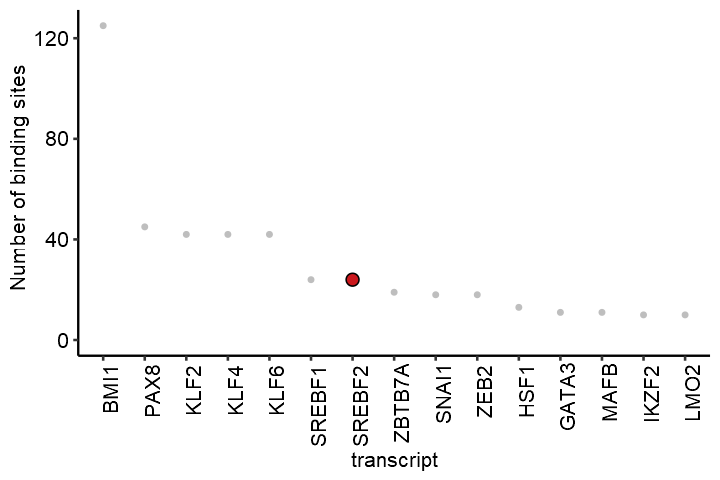

In [58]:
options(repr.plot.width=6, repr.plot.height=4)
TX_ABUN <- TFRankR(DT = TX_TOT_Species, sortBy = "abundance", dec = TRUE)
TX_ABUN <- TX_ABUN[TX_ABUN$Species == "Human",]
TX_ABUN  <- TX_ABUN[!duplicated(TX_ABUN$Targeting_Factor),]
TX_ABUN <- TX_ABUN[TX_ABUN$Number_Hits > 9,]
#### cross reference to hypoxia data and replot 
hypoxia <- fread("./data/15 hypoxia raw merge genes.xls")
TX_ABUN <- TX_ABUN[(TX_ABUN$Targeting_Factor %in% hypoxia$wikigene_name),]

g1 <- ggplot(TX_ABUN,
             aes(y=Number_Hits, x=reorder(`Targeting_Factor`,-Number_Hits), ymin=0, ymax=Number_Hits), col="blue") +
  geom_point(size=.9, color="grey") +
  geom_point(data = subset(TX_ABUN, Targeting_Factor == "SREBF2"),
             aes(x=reorder(`Targeting_Factor`, -Number_Hits), y=Number_Hits),
             shape = 21, size = 3, colour = "black", fill ="#CB181D" )+xlab("transcript")+ylab("Number of binding sites")+
 theme(plot.title = element_text(size = 10,colour="black"))+
 theme(axis.text=element_text(size=rel(0.5)),axis.title=element_text(size=rel(0.6)))+
  theme_pubr() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))
g1
#TX_ABUN

#### Return the miR210 promoter with the closest SREBP2 binding site upstream of the transcroption start site.

In [ ]:
TX_TOT_Species[Targeting_Factor == "SREBF2" & start == 2300,] $Sequence

# KEGG pathway analysis

#### obtain NCBI information

In [59]:
rawmerge <- fread("./data/19 OSA RNAseq raw merge genes.xls")
go <- BioMartR(value = rawmerge$ensembl_gene_id, 
               mart = "ENSEMBL_MART_ENSEMBL", 
               species = "hsapiens_gene_ensembl", 
               attribute = c("ensembl_gene_id", "entrezgene_id"),
               filter_by = 'ensembl_gene_id')
head(go, 1)

ensembl_gene_id,entrezgene_id
<chr>,<int>
ENSG00000000003,7105


#### Categorize and rank all KEGG pathways 

In [60]:
#### format data ####
pathway <- merge(go, rawmerge,  by = "ensembl_gene_id")[,c(2,11:18)]
pathnames <- pathway$entrezgene_id
pathway <- as.matrix(pathway[,2:9])
rownames(pathway) <- pathnames 
#### set up comparison information
cn <- colnames(pathway)
hn <- grep('Z',cn, ignore.case =TRUE)
dcis <- grep('OSA',cn, ignore.case =TRUE)
#### run analysis on canonical signaling and metabolic pathways
data(kegg.gs)
pathway.kegg.p <- gage(pathway, gsets = kegg.gs, ref = hn, samp = dcis)
pathway.d <- gagePrep(pathway, ref = hn, samp = dcis)
#### print out upregulated pathways
sel <- pathway.kegg.p$greater[, "p.val"] < 0.1 & !is.na(pathway.kegg.p$greater[, "p.val"])
path.ids <- rownames(pathway.kegg.p$greater)[sel]
path.ids2 <- substr(path.ids, 1, 8)
#dir.create("./results/pathway_analysis/up")
#setwd("./results/pathway_analysis/up")
#pv.out.list <- sapply(path.ids2, function(pid) pathview(gene.data = pathway.d[,1:2], pathway.id = pid, species = "hsa"))
#setwd(homedir)
#### print out downregulated pathways
sel <- pathway.kegg.p$greater[, "p.val"] < 0.1 & !is.na(pathway.kegg.p$greater[, "p.val"])
path.ids <- rownames(pathway.kegg.p$less)[sel]
path.ids2 <- substr(path.ids, 1, 8)
#dir.create("./results/pathway_analysis/down")
#setwd("./results/pathway_analysis/down")
#pv.out.list <- sapply(path.ids2, function(pid) pathview(gene.data = pathway.d[,1:2], pathway.id = pid, species = "hsa"))
#setwd(homedir)

#### Generate a plot of the overall signifigance of each canonical signaling/metabolic pathway 

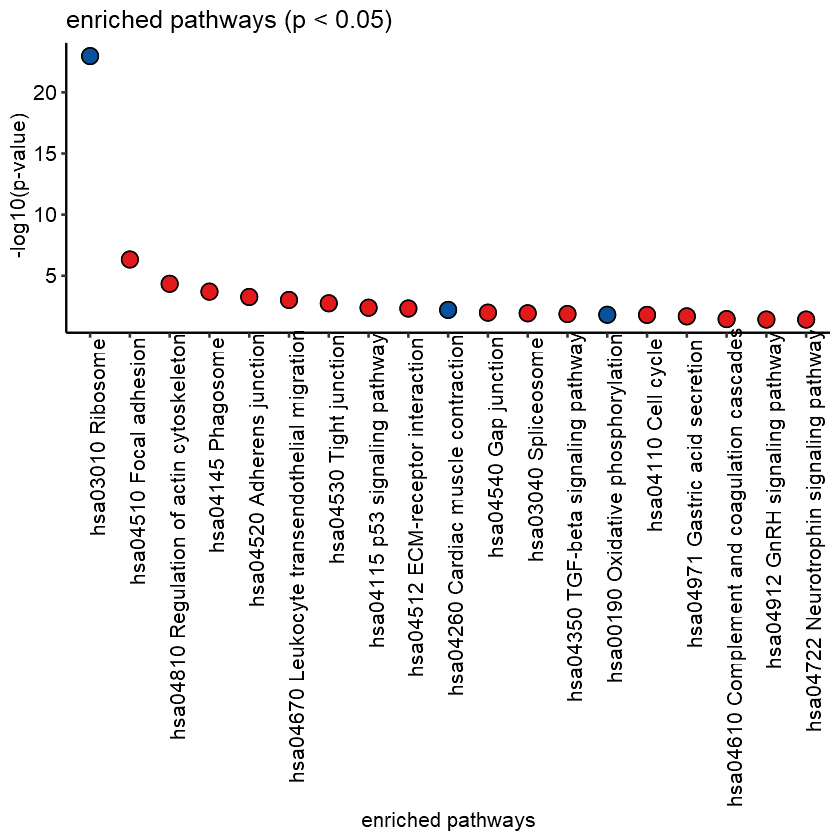

In [61]:
options(repr.plot.width=7, repr.plot.height=7)
#### upregulated pathways
rnames <- rownames(pathway.kegg.p$greater)
great <- data.table(pathway.kegg.p$greater)
great$pathname <- rnames
great <- great[,c(3,10)][complete.cases(great),]
great$direction <- "upregulated"
#### downregulated pathways
rnames <- rownames(pathway.kegg.p$less)
less <- data.table(pathway.kegg.p$less)
less$pathname <- rnames
less <- less[,c(3,10)][complete.cases(less),]
less$direction <- "downregulated"
#### compined pathways
sigpathways <- rbind(great, less)
sigpathways$logp <- -log10(sigpathways$p.val)
#### subset significant pathways 
sigpathways <- sigpathways[sigpathways$p.val < 0.05]
#### Generate plot ####
p <- ggplot(sigpathways, aes(x= reorder(`pathname`, -`logp`), y= `logp`)) + 
  geom_point(shape = 21, size = 4, colour = "black", fill = "gray") + 
  theme_pubr() +
  labs(x = "enriched pathways", y = "-log10(p-value)") +
  ggtitle("enriched pathways (p < 0.05)")+
  theme(axis.text.x = element_text(angle = 90, hjust = 1))+
  geom_point(data = subset(sigpathways, direction == "upregulated"),
             aes(x=reorder(`pathname`, -`logp`), y=`logp`),
             shape = 21, size = 4, colour = "black", fill = "#E31A1C") +
  geom_point(data = subset(sigpathways, direction == "downregulated"),
             aes(x=reorder(`pathname`, -`logp`), y=`logp`),
             shape = 21, size = 4, colour = "black", fill = "#08519C");p

#### Plot pathways of interest

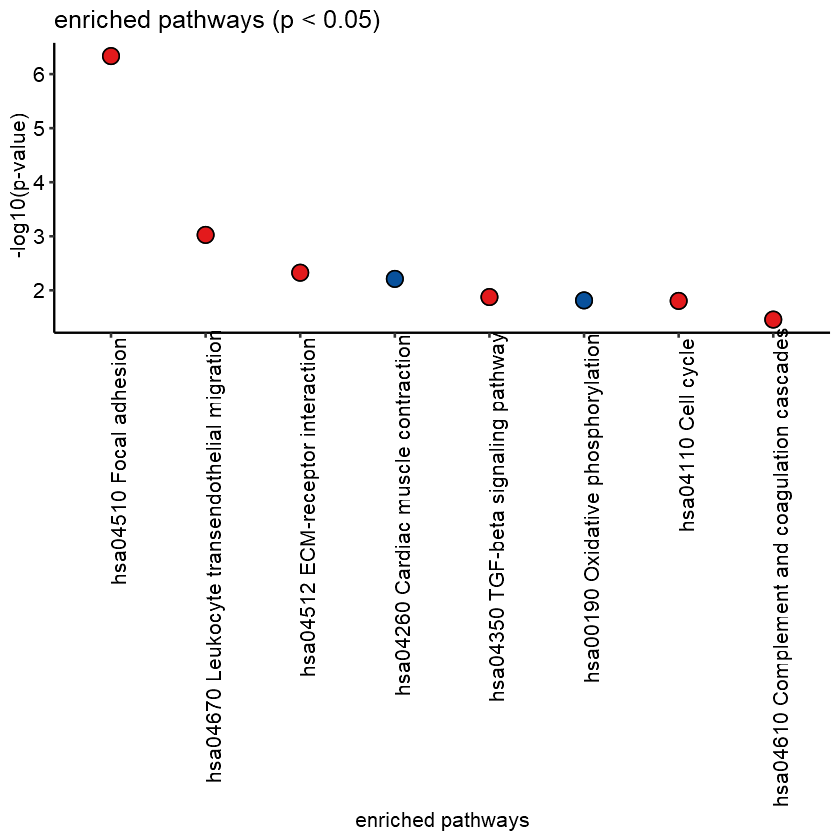

In [62]:
sigpathwaysint <- sigpathways[grepl("Focal", sigpathways$pathname) | 
                                grepl("Leukocyte", sigpathways$pathname) | 
                                grepl("ECM", sigpathways$pathname) |
                                grepl("Cardiac", sigpathways$pathname) | 
                                grepl("TGF", sigpathways$pathname) | 
                                grepl("Oxidative", sigpathways$pathname) | 
                                grepl("Cell cycle", sigpathways$pathname) | 
                                grepl("Complement", sigpathways$pathname),]
#### Generate plot ####
p <- ggplot(sigpathwaysint, aes(x= reorder(`pathname`, -`logp`), y= `logp`)) + 
  geom_point(shape = 21, size = 4, colour = "black", fill = "gray") + 
  theme_pubr() +
  labs(x = "enriched pathways", y = "-log10(p-value)") +
  ggtitle("enriched pathways (p < 0.05)")+
  theme(axis.text.x = element_text(angle = 90, hjust = 1))+
  geom_point(data = subset(sigpathwaysint, direction == "upregulated"),
             aes(x=reorder(`pathname`, -`logp`), y=`logp`),
             shape = 21, size = 4, colour = "black", fill = "#E31A1C") +
  geom_point(data = subset(sigpathwaysint, direction == "downregulated"),
             aes(x=reorder(`pathname`, -`logp`), y=`logp`),
             shape = 21, size = 4, colour = "black", fill = "#08519C");p

#### Plot specific KEGG pathways

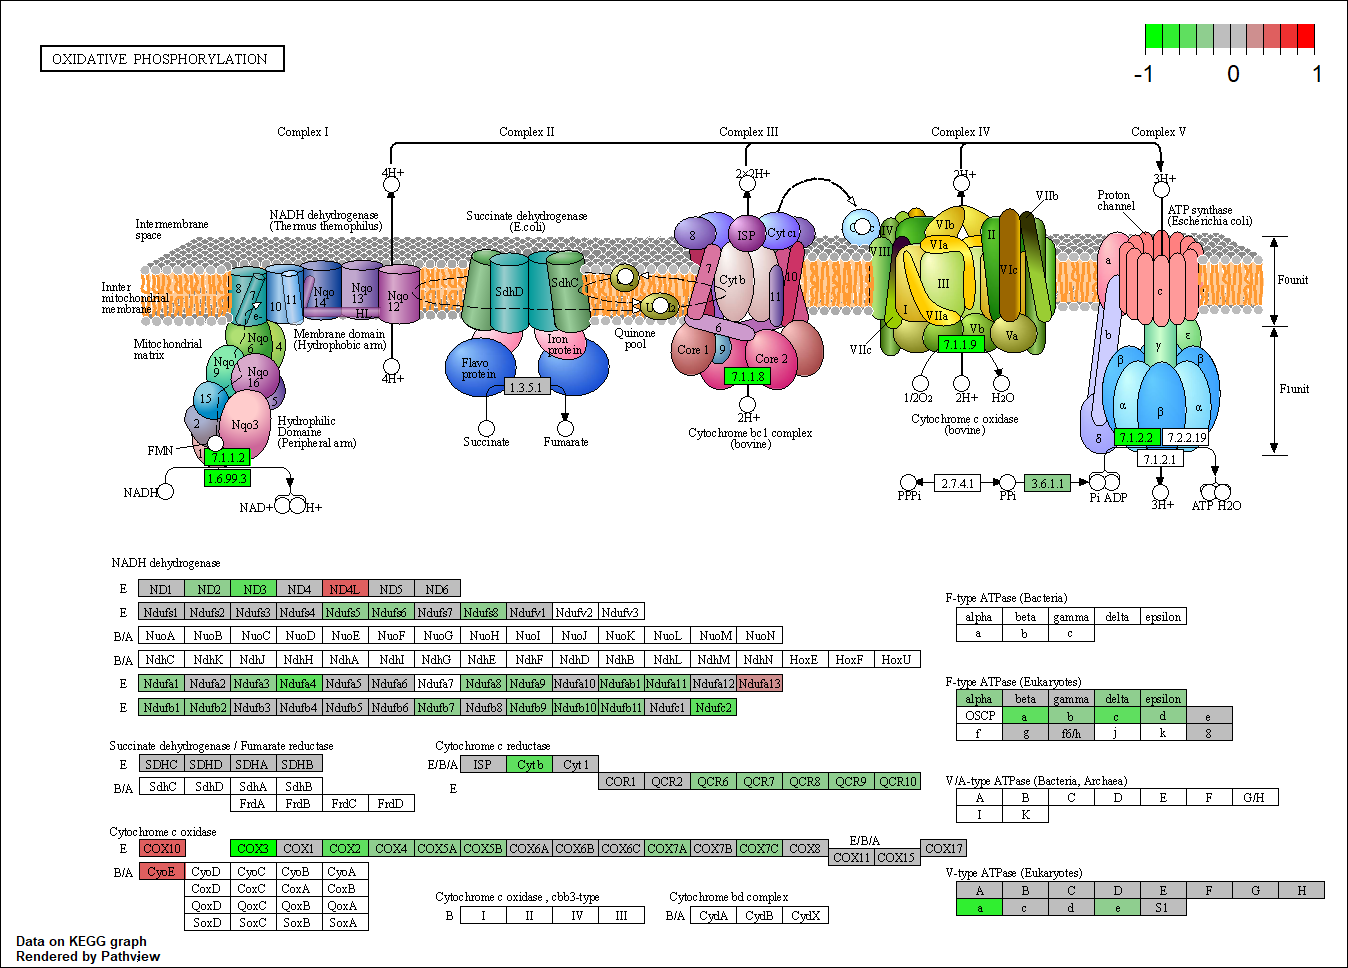

In [64]:
options(warn=1)
#### format data ####
pathway <- merge(go, rawmerge,  by = "ensembl_gene_id")[,c(2,6)]
pathnames <- pathway$entrezgene_id
pathway <- matrix(pathway[,2])
rownames(pathway) <- pathnames 
#### plot pathway analysis ####
pv.out <- pathview(gene.data = pathway[, 1], pathway.id = "00190", species = "hsa", out.suffix = "gse16873")
display_png(file="hsa00190.gse16873.png") 

# Predict miR210 targets involved in mitochondrial function

#### Identify genes that are differentially regulated by OSA serum related to mitochondrial function
The gene ontology annotations were obtained by querying biomart for GO terms and definitions for genes housed in the RNAseq data from HUVECs treated with serum isolated from people with OSA compared to healthy controls. 

In [65]:
dt <- fread("./data/17 edgeRGOannotation.xls")
dt <- dt[,c(1,2,5,8,9,12,13)]
#### subset genes that have a p-value less than 0.05
dtsig <- dt[dt$`OSA-CTRL_PValue` < 0.05,]
nrow(dtsig[!duplicated(dtsig$ensembl_gene_id),])
#### subset out genes involved in mitochondrial function
mito <- dtsig[grepl("mitochondria", dtsig$definition_1006, ignore.case = TRUE),]
mitoduprm <- mito[!duplicated(mito$ensembl_gene_id),]
#### remove erroneously identified genes
mitoduprm <- mitoduprm[!grepl("ribo", mitoduprm$definition_1006, ignore.case = TRUE),]
mitoduprm <- mitoduprm[!grepl("nerve", mitoduprm$definition_1006, ignore.case = TRUE),]
mitoduprm <- mitoduprm[!grepl("release of cytochrome c", mitoduprm$definition_1006, ignore.case = TRUE),]
mitoduprm <- mitoduprm[!grepl("brown adipocyte", mitoduprm$definition_1006, ignore.case = TRUE),]
mitoduprm <- mitoduprm[!grepl("movement of cytochrome c from the mitochondrial", mitoduprm$definition_1006, ignore.case = TRUE),]
mitoduprm <- mitoduprm[!grepl(" programmed necrotic cell death", mitoduprm$definition_1006, ignore.case = TRUE),]
#### add KEGG pathway genes
one <- dt[grepl("NADH dehydrogenase", dt$wikigene_description, ignore.case = TRUE),]
two <- dt[grepl("NDUFS", dt$wikigene_name, ignore.case = TRUE),]
three <- dt[grepl("NDUFA", dt$wikigene_name, ignore.case = TRUE),]
four <- dt[grepl("NDUFB", dt$wikigene_name, ignore.case = TRUE),]
five <- dt[grepl("COX", dt$wikigene_name, ignore.case = TRUE),]
six <- dt[grepl("ATP synthase", dt$wikigene_description, ignore.case = TRUE),]
mitoduprm <- rbind (one, two, three, four, five, six, mitoduprm)
mitoduprm <- mitoduprm[!duplicated(mitoduprm$ensembl_gene_id),]
head(mitoduprm, 1)
#writab(mitoduprm, fname="./results/47.1 mitochondrial genes.xls")

[1] 467

ensembl_gene_id,OSA-CTRL_logFC,OSA-CTRL_PValue,wikigene_name,wikigene_description,go_id,definition_1006
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
ENSG00000198695,0.04432276,0.7245394,ND6,"NADH dehydrogenase, subunit 6 (complex I)",GO:0032981,"The aggregation, arrangement and bonding together of a set of components to form mitochondrial respiratory chain complex I."


#### Get mRNA sequences for identified transcripts

In [66]:
#### Load the sequence compiled mRNA database
setwd("C:/Users/breng/Dropbox/Brendan Documents/programming/bioinformatics/cDNA_transcriptome/2016-3-6 cDNA transcriptomes") # Windows
mRNAs <- fread("3 Annotated species mRNA compilation.xls")
setwd(homedir)
mRNAs$external_gene_name <- toupper(mRNAs$external_gene_name)
#### Return mRNAs for DEGs identified
mitoduprmless <- mitoduprm[mitoduprm$`OSA-CTRL_logFC` < 0,]
ID2 <- toupper(mitoduprmless$wikigene_name)
TRANS_CHR <- mRNAs[(mRNAs$external_gene_name %in% ID2),]
TRANS_CHR <- TRANS_CHR[order(TRANS_CHR$external_gene_name),]
#### Remove erroneous chromosome labels
CHR_Labels <- c(1:21, "X", "Y")
TRANS_CHR <- TRANS_CHR[(TRANS_CHR$chromosome_name %in% CHR_Labels),]
#### Relabel chromosome designations for use with the getSeq Function.
TRANS_CHR <- ChromLabel(TRANS_CHR)
#### Sort out Splice Variants so that the longest transcript of each protein is represented only once in each species 
setnames(TRANS_CHR, c("ensembl_transcript_id", "Sequence", "Species_File", "Scientific_Name", "Common_Name", "external_gene_name", "transcription_start_site", "transcript_start", "transcript_end", "chromosome_name"),
         c("ensembl_transcript_id", "Sequence", "Species_File", "Scientific_Name", "Common_Name", "external_gene_name", "transcription_start_site", "transcript_start", "transcript_end", "chromosome_name"))
PROMTrans <- VariantSort(TRANS_CHR, variant = "MAX")
PROMTrans[1,c(1, 3:11), with = FALSE]
#writab(PROMTrans, fname="./data/mito Longest Variant Transcripts.xls")

  |======================================================================| 100%


ensembl_transcript_id,Species_File,Scientific_Name,Common_Name,external_gene_name,transcription_start_site,transcript_start,transcript_end,chromosome_name,Length
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<int>
ENSACAT00000010495,Anolis_carolinensis.AnoCar2.0.cdna.all.fa.gz,Anolis_carolinensis,Lizard,ACKR3,120160338,120160338,120161432,chr1,1095


#### load and format miRNA sequences 

In [67]:
setwd("C:/Users/breng/Dropbox/Brendan Documents/programming/bioinformatics/miRNA_transcriptome/2018-3-16 miRNA sequences") # Windows
MatMiRNA <- fread("unqueried MiRNA data table.xls")
setwd(homedir)
MatMiRNA <- MatMiRNA[MatMiRNA$miRNA_type == "MATURE",]
#### Reformat the table to include the species 
MiRNADT <- MatMiRNA; MiRNADT <- MiRNASpeciesAnnot(MiRNADT)
#### remove the species designation from the miRNA name and add it to another column
MiRNADT <- MiRNAname(MiRNADT)
#### Determine miRNA seed sequence (positions 2-8 from the 5' end). Must be perfectly complimentary for miRNA binding to mRNA 
MiRNADT <- MISeed(MiRNADT)
#### identify the miRNA query sequence 
MiRNADT <- MIQuerySeq(MiRNADT, wobble = TRUE)
#### subset miR-210
MiRNADT <- MiRNADT[grepl("mir-210", MiRNADT$miRNA, ignore.case = TRUE),];head(MiRNADT,1)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


Sequence,miRNA_Name,miRNA_type,Common_Name,Scientific_Name,miRNA,seed_Sequence,Query_Sequence
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AGCCCCUGCCCACCGCACACUG,HSA-MIR-210-5P,MATURE,Human,Homo_sapiens,MIR-210-5P,GCCCCUG,(C|T)(A|G)GGGG(C|T)


#### Query miRNA's against mRNA sequences to identify what mRNA sequences contain a miR SEED sequence

In [68]:
PROMTransmRNA <- PROMTrans
setnames(PROMTransmRNA, colnames(PROMTransmRNA),
         c("ensembl_transcript_id", "Sequence", "Species_File", "Scientific_Name", "Species", "external_gene_name", "transcription_start_site", "transcript_start", "transcript_end", "chromosome_name", "Length"))
setnames(MiRNADT, c("Sequence", "miRNA_Name", "miRNA_type", "Common_Name", "Scientific_Name", "seed_Sequence", "Query_Sequence"),
         c("Sequence", "miRNA_Name", "miRNA_type", "Species", "Scientific_Name", "seed_Sequence", "Query_Sequence"))
Spec <- c("Homo_sapiens", "Mus_musculus", "Rattus_norvegicus")
MiRNAhitstot <- MIRNATargetpredict(MiRNADT = MiRNADT, mRNADT = PROMTransmRNA, type = "Multiple", Spe = Spec)
#### remove the species designation from the miRNA name and add it to another column in the new dataset 
MiRNAhitstot <- MiRNAname(MiRNAhitstot) 
#### Retain only miRNA mRNA association conservation between HMR for each mRNA
setnames(MiRNAhitstot, c("Query_Sequence", "start", "end", "miRNA_Name", "mRNA_Name", "Number_Hits", "length", "Sequence", "Species", "miRNA"),
         c("Query_Sequence", "start", "end", "miRNA_Name", "gene_symbol", "Number_Hits", "length", "Sequence", "Species", "Targeting_Factor"))
MiRNAhitstot <- SpeciesTFCons(DT = MiRNAhitstot,Spec = c("Homo_sapiens", "Mus_musculus", "Rattus_norvegicus"), provide = "TF_Target")
#### Annotate identified putative miR-210 targets with food changes
#mitoduprm 
miR210targ <- MiRNAhitstot#<- fread("./results/49 miR210 target hits HMR conserved.xls")
mitoduprm$miRtarget <- "not miR210 target"
mitoduprm[(mitoduprm$wikigene_name %in% miR210targ$gene_symbol),]$miRtarget <- "miR210 target"
head(mitoduprm,1)

  |======================================================================| 100%
  |======================================================================| 100%


ensembl_gene_id,OSA-CTRL_logFC,OSA-CTRL_PValue,wikigene_name,wikigene_description,go_id,definition_1006,miRtarget
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
ENSG00000198695,0.04432276,0.7245394,ND6,"NADH dehydrogenase, subunit 6 (complex I)",GO:0032981,"The aggregation, arrangement and bonding together of a set of components to form mitochondrial respiratory chain complex I.",not miR210 target


#### Generate a heatmap of genes involved in mitochondrial function

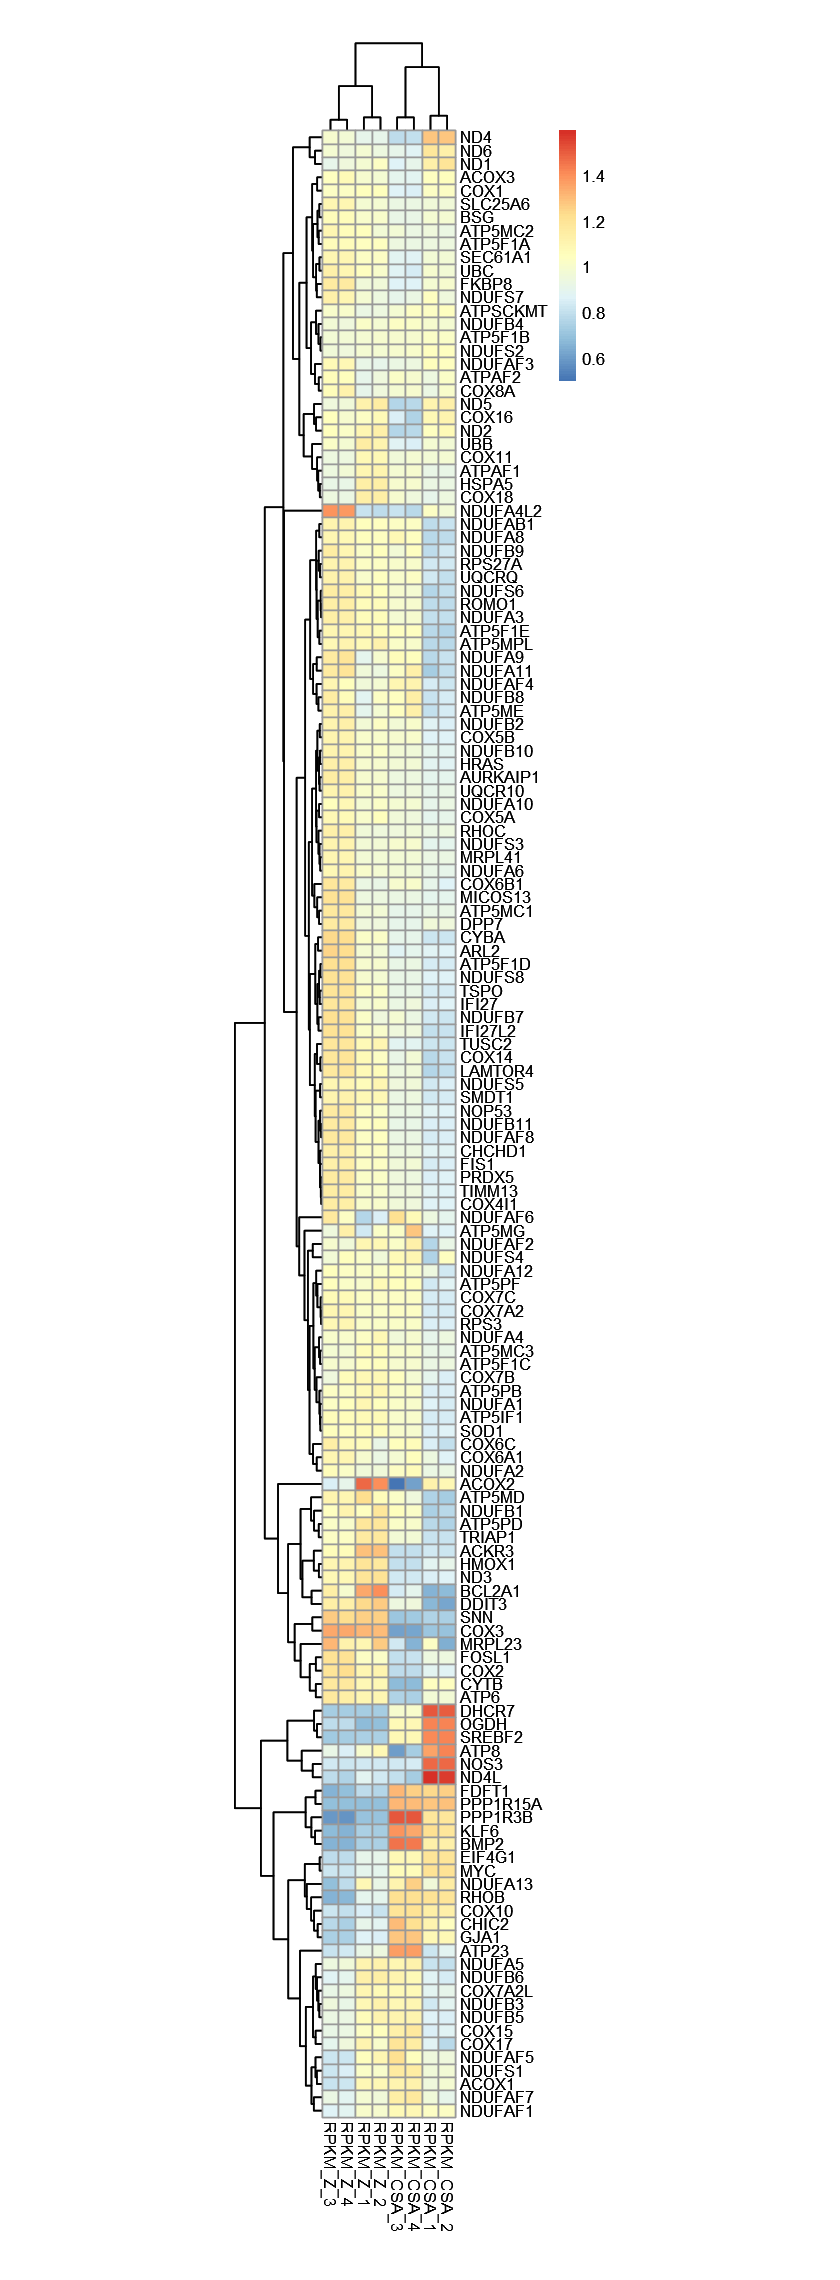

In [69]:
options(repr.plot.width=7, repr.plot.height=19)
mitoduprmsub <- mitoduprm[,c(1:4,8)]
rawmerge <- fread(osaseq)
RPKM <- fread("./data/4 OSA rpkmDFeByg.xls")
setnames(RPKM, colnames(RPKM), c("ensembl_gene_id", "RPKM_OSA_1",  "RPKM_OSA_2",  "RPKM_OSA_3",  "RPKM_OSA_4",  "RPKM_Z_1",  "RPKM_Z_2",  "RPKM_Z_3", "RPKM_Z_4"))
RPKMmer <- merge(rawmerge, RPKM, by = "ensembl_gene_id")
RPKMmito <- RPKMmer[(RPKMmer$ensembl_gene_id %in% mitoduprmsub$ensembl_gene_id),]
#### format data ####
DATA <- RPKMmito[,c(3, 18:25)]
DATA <- as.data.frame(DATA)
#### normalize data to difference from fow means ####
DAT <- DATA[,2:9]
means <- rowMeans(DAT)
table <- data.table()
for(i in 1:length(means)){
  norm <- as.numeric(DAT[i,])/means[i]
  dt <- t(data.table(norm))
  rownames(dt) <- i
  dt <- data.table(dt)
  table <- rbind(table, dt)
}
setnames(table, colnames(table), c("RPKM_OSA_1", "RPKM_OSA_2", "RPKM_OSA_3", "RPKM_OSA_4", "RPKM_Z_1", "RPKM_Z_2", "RPKM_Z_3", "RPKM_Z_4"))
table <- as.data.frame(table)
row.names(table) <- DATA$wikigene_name

DATA_matrix <- data.matrix(table)
p <- pheatmap(DATA_matrix,
              cellwidth = 10,
              cellheight = 8,
              cluster_row = TRUE,
              cluster_cols = TRUE
);p

#### Make heatmap of only downregulated genes annotated with target of miR-210 

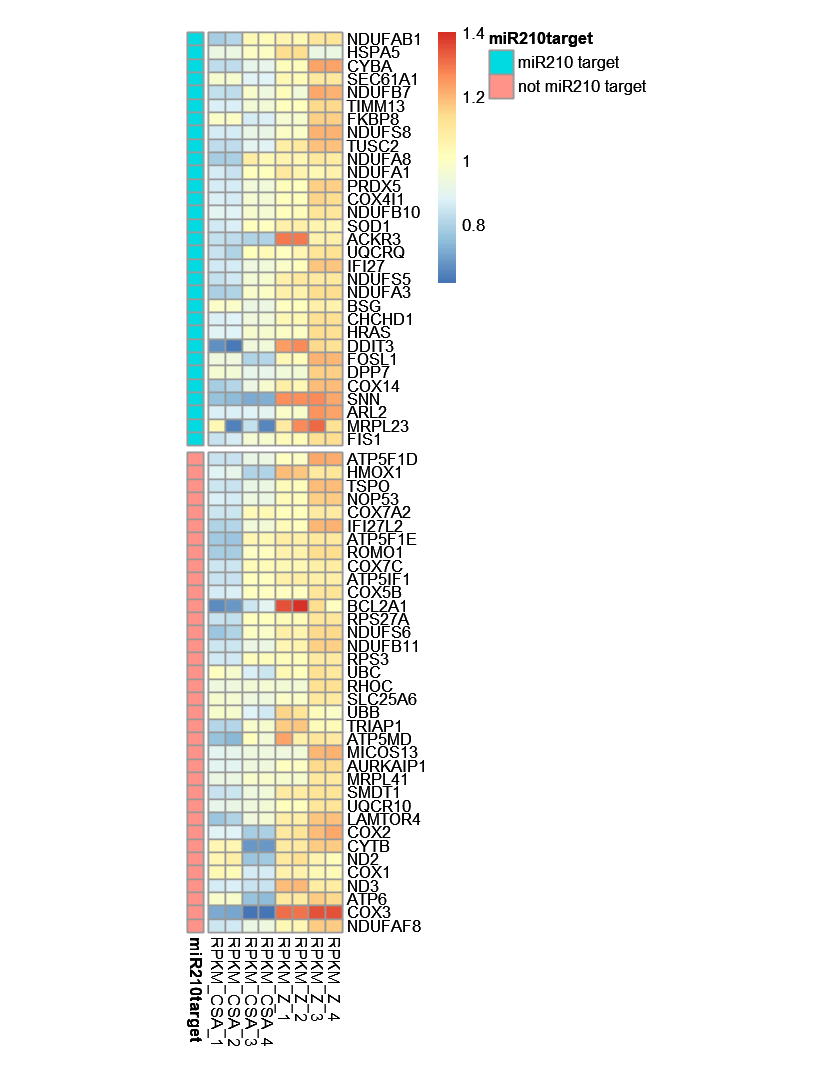

In [70]:
options(repr.plot.width=7, repr.plot.height=9)
mitoduprmsub <- mitoduprm[,c(1:4,8)]
mitoduprmsub <- mitoduprmsub[mitoduprmsub$`OSA-CTRL_PValue` < 0.05,]
mitoduprmsubless <- mitoduprmsub[mitoduprmsub$`OSA-CTRL_logFC` < 0,]
rawmerge <- fread(osaseq)
RPKM <- fread("./data/4 OSA rpkmDFeByg.xls")
setnames(RPKM, colnames(RPKM), c("ensembl_gene_id", "RPKM_OSA_1",  "RPKM_OSA_2",  "RPKM_OSA_3",  "RPKM_OSA_4",  "RPKM_Z_1",  "RPKM_Z_2",  "RPKM_Z_3", "RPKM_Z_4"))
RPKMmer <- merge(rawmerge, RPKM, by = "ensembl_gene_id")
RPKMmito <- RPKMmer[(RPKMmer$ensembl_gene_id %in% mitoduprmsubless$ensembl_gene_id),]
RPKMmito <- merge(RPKMmito, mitoduprmsubless[,c(1,5)], by = "ensembl_gene_id")
RPKMmito <- RPKMmito[order(RPKMmito$miRtarget),]
#### format data ####
DATA <- RPKMmito[,c(3, 18:25)]
DATA <- as.data.frame(DATA)
#### normalize data to difference from fow means ####
DAT <- DATA[,2:9]
means <- rowMeans(DAT)
table <- data.table()
for(i in 1:length(means)){
  norm <- as.numeric(DAT[i,])/means[i]
  dt <- t(data.table(norm))
  rownames(dt) <- i
  dt <- data.table(dt)
  table <- rbind(table, dt)
}
setnames(table, colnames(table), c("RPKM_OSA_1", "RPKM_OSA_2", "RPKM_OSA_3", "RPKM_OSA_4", "RPKM_Z_1", "RPKM_Z_2", "RPKM_Z_3", "RPKM_Z_4"))
table <- as.data.frame(table)
row.names(table) <- DATA$wikigene_name
DATA_matrix <- data.matrix(table)

annotation_row = data.frame(
  miR210target = factor(RPKMmito$miRtarget)
)
rownames(annotation_row) = RPKMmito$wikigene_name

p <- pheatmap(DATA_matrix,
              cellwidth = 10,
              cellheight = 8,
              cluster_row = FALSE,
              cluster_cols = FALSE,
              gaps_row=c(31),
              annotation_row = annotation_row
);p

#### End of analysis